# Airline Passengers Dataset

## Setup

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Read in the timeseries data of airline passenger traffic

In [2]:
data = pd.read_csv('airline-passenger-traffic.csv', header=None)
data.columns = ['month', 'passengers']
data['month'] = pd.to_datetime(data.month, format="%Y-%m")
data = data.set_index('month')
data.shape

(144, 1)

In [3]:
data.head()

,passengers
month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


## Time Series Analysis

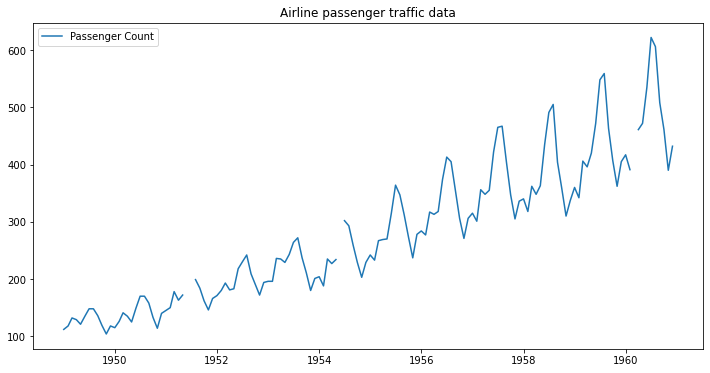

In [4]:
plt.figure(figsize=(12,6))
plt.plot(data.index, data.passengers, label='Passenger Count')
plt.legend(loc='best')
plt.title('Airline passenger traffic data')
plt.show()

## Missing Value Treatment

### Mean Imputation

In [5]:
data = data.assign(Passenger_Mean_Imputation = data.passengers.fillna(data.passengers.mean()))

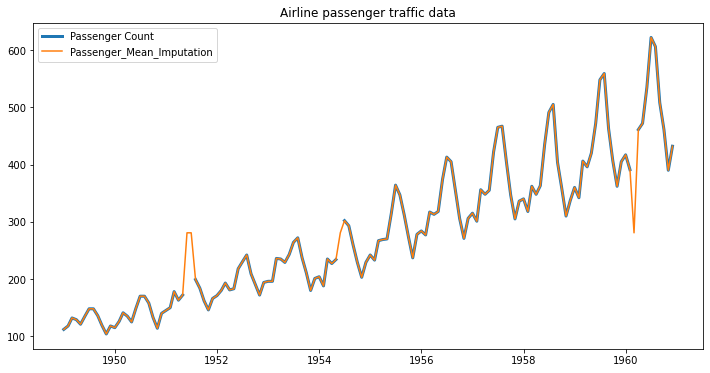

In [6]:
plt.figure(figsize=(12,6))
plt.plot(data.index, data.passengers, label='Passenger Count', linewidth=3)
plt.plot(data.index, data.Passenger_Mean_Imputation, label='Passenger_Mean_Imputation')
plt.legend(loc='best')
plt.title('Airline passenger traffic data')
plt.show()

### Linear Interpolation Imputation

In [7]:
data = data.assign(Passenger_Linear_Imputation = data.passengers.interpolate(method='linear'))

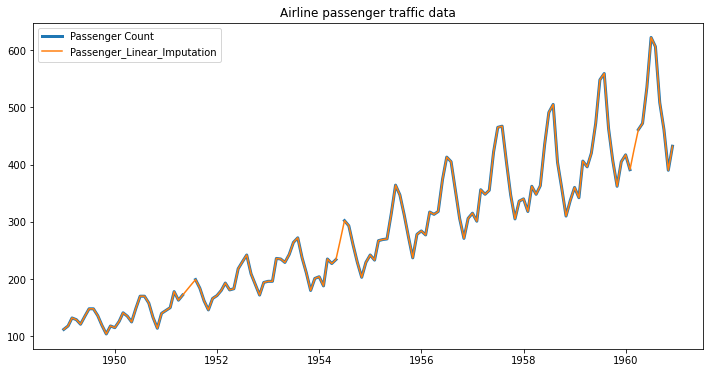

In [8]:
plt.figure(figsize=(12,6))
plt.plot(data.index, data.passengers, label='Passenger Count', linewidth=3)
plt.plot(data.index, data.Passenger_Linear_Imputation, label='Passenger_Linear_Imputation')
plt.legend(loc='best')
plt.title('Airline passenger traffic data')
plt.show()

In [9]:
data['passengers'] = data['Passenger_Linear_Imputation']

## Outlier detection

<function matplotlib.pyplot.show(*args, **kw)>

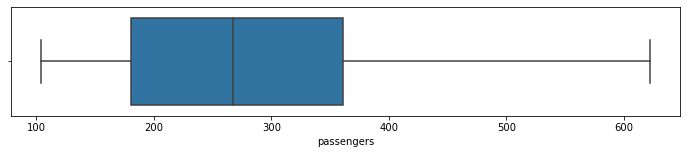

In [10]:
plt.figure(figsize=(12,2))
sns.boxplot(x=data.passengers, whis=1.5)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

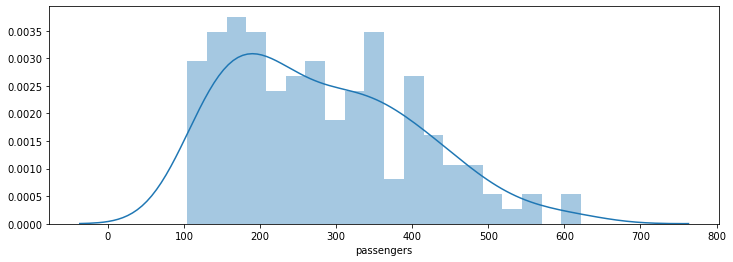

In [11]:
plt.figure(figsize=(12,4))
sns.distplot(data.passengers, bins=20, )
plt.show

## Time Series Decomposition

### Additive Seasonal Decomposition

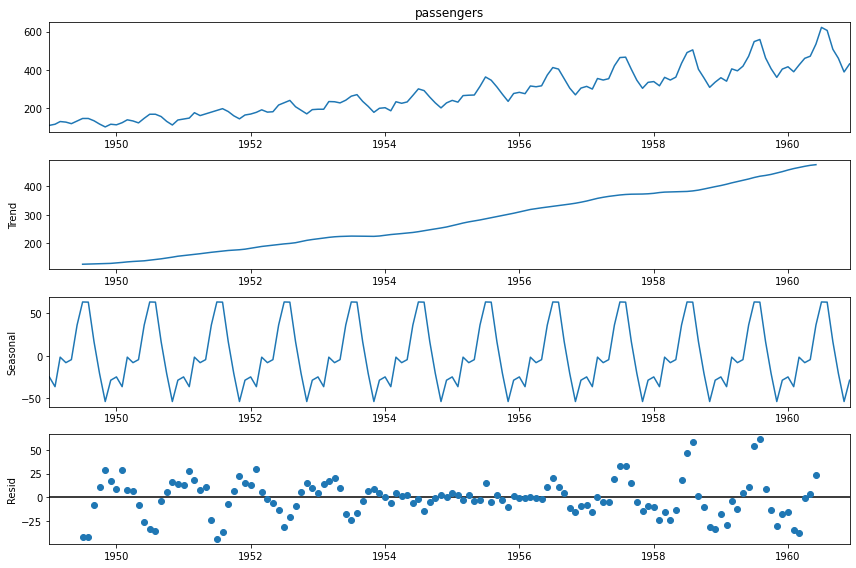

In [12]:
from pylab import rcParams
import statsmodels.api as sm

rcParams['figure.figsize'] = (12,8)
decomposition = sm.tsa.seasonal_decompose(data.passengers, model='additive')
decomposition.plot()
plt.show()

### Multiplicative Seasonal Decomposition

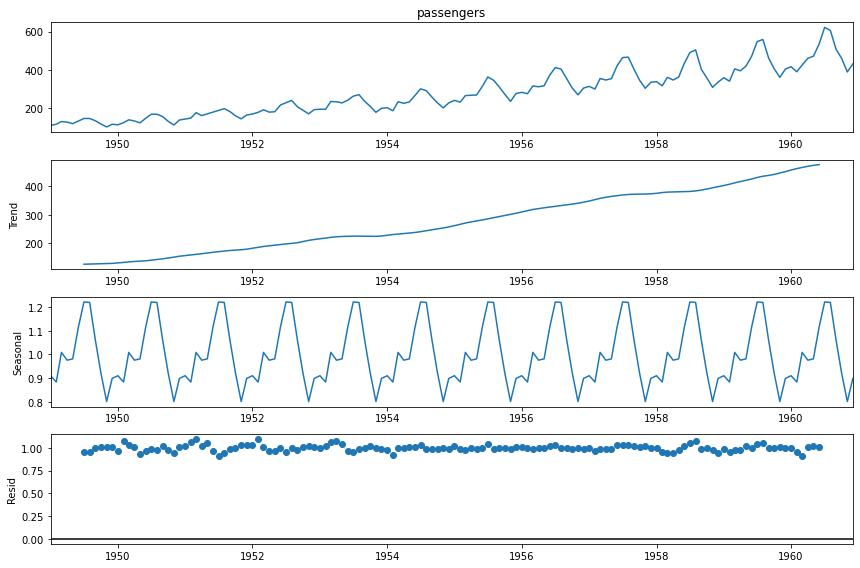

In [13]:
decomposition = sm.tsa.seasonal_decompose(data.passengers, model='multiplicative')
decomposition.plot()
plt.show()

In [14]:
decomposition.resid.max()

1.0939261799794415

## Build and Evaluate Time Series Models

In [15]:
# Split into train test
train_len = 120
train = data[:train_len]
test = data[train_len:]

### Naive Method

In [16]:
y_hat_naive = test.copy()
y_hat_naive['naive_forecast'] = train['passengers'][train_len-1]

### Simple Average

In [17]:
y_hat_simple = test.copy()
y_hat_simple['simple_avg_forecast'] = train['passengers'].mean()

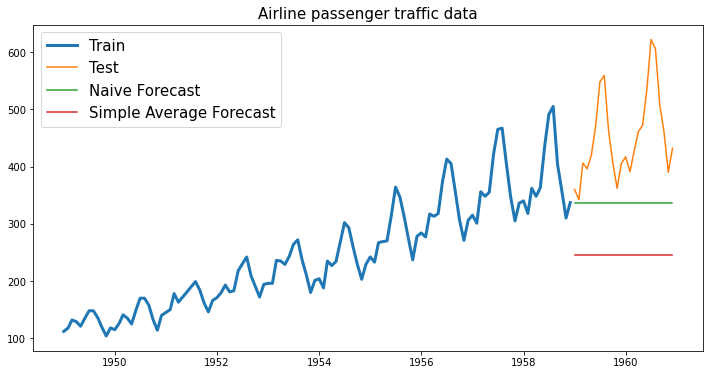

In [18]:
plt.figure(figsize=(12,6))
plt.plot(train.index, train.passengers, label='Train', linewidth=3)
plt.plot(test.index, test.passengers, label='Test')
plt.plot(y_hat_naive.index, y_hat_naive.naive_forecast, label='Naive Forecast')
plt.plot(y_hat_simple.index, y_hat_simple.simple_avg_forecast, label='Simple Average Forecast')
plt.legend(loc='best', fontsize=15)
plt.title('Airline passenger traffic data', fontsize=15)
plt.show()

## Calculate RMSE and MAPE

In [19]:
# RMSE

from sklearn.metrics import mean_squared_error
RMSE_naive = np.sqrt(mean_squared_error(y_true=test['passengers'], y_pred=y_hat_naive['naive_forecast']))
RMSE_simple = np.sqrt(mean_squared_error(y_true=test['passengers'], y_pred=y_hat_simple['simple_avg_forecast']))

In [20]:
# MAPE

MAPE_naive = np.mean ( abs(test['passengers'] - y_hat_naive['naive_forecast']) / test['passengers'] ) * 100
MAPE_simple = np.mean ( abs(test['passengers'] - y_hat_simple['simple_avg_forecast']) / test['passengers'] )* 100

In [21]:
# Define Dataframe
df_results = pd.DataFrame()
df_results['Method'] = ['Naive', 'Simple']
df_results['RMSE'] = [RMSE_naive, RMSE_simple]
df_results['MAPE'] = [MAPE_naive, MAPE_simple]
df_results

,Method,RMSE,MAPE
0,Naive,137.510454,23.632535
1,Simple,219.689487,44.278566


### Simple Moving Average

In [22]:
y_hat_sma = data.copy()
ma_window = 12
y_hat_sma['sma_forecast'] = data['passengers'].rolling(ma_window).mean()
y_hat_sma['sma_forecast'][train_len:] = y_hat_sma['sma_forecast'][train_len-1]

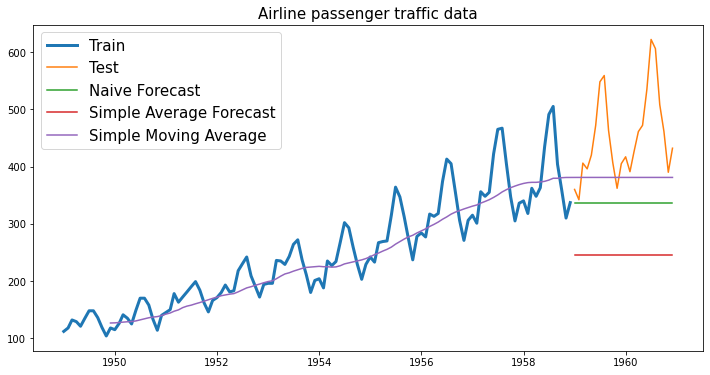

In [23]:
plt.figure(figsize=(12,6))
plt.plot(train.index, train.passengers, label='Train', linewidth=3)
plt.plot(test.index, test.passengers, label='Test')
plt.plot(y_hat_naive.index, y_hat_naive.naive_forecast, label='Naive Forecast')
plt.plot(y_hat_simple.index, y_hat_simple.simple_avg_forecast, label='Simple Average Forecast')
plt.plot(y_hat_sma.index, y_hat_sma.sma_forecast, label='Simple Moving Average')
plt.legend(loc='best', fontsize=15)
plt.title('Airline passenger traffic data', fontsize=15)
plt.show()

In [24]:
# RMSE, MAPE

from sklearn.metrics import mean_squared_error
RMSE_sma = np.sqrt(mean_squared_error(y_true=test['passengers'], y_pred=y_hat_sma['sma_forecast'][train_len:]))
MAPE_sma = np.mean ( abs(test['passengers'] - y_hat_sma['sma_forecast'][train_len:]) / test['passengers'] ) * 100


In [25]:
new_row = {'Method': 'Simple Moving Average', 'RMSE': RMSE_sma, 'MAPE': MAPE_sma}
df_results = df_results.append(new_row, ignore_index=True)
df_results

,Method,RMSE,MAPE
0,Naive,137.510454,23.632535
1,Simple,219.689487,44.278566
2,Simple Moving Average,103.331788,15.535497


## Simple Exponential Smooting

In [26]:
# Import package
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
model = SimpleExpSmoothing(train['passengers'])
model_fit = model.fit(smoothing_level=0.2, optimized=False)
model_fit.params
# If optimized=False, we are saying what should be the level of smoothing used in the model. 
# Otherwise with True we let the model pick the correct level of smoothing by itself.

{'smoothing_level': 0.2,
 'smoothing_slope': None,
 'smoothing_seasonal': None,
 'damping_slope': nan,
 'initial_level': 112.0,
 'initial_slope': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [27]:
# Predict
y_hat_ses = test.copy()
y_hat_ses['SES_forecast'] = model_fit.forecast(24)

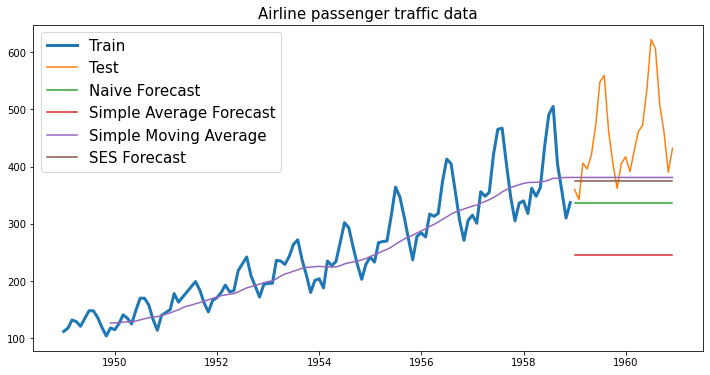

In [28]:
plt.figure(figsize=(12,6))
plt.plot(train.index, train.passengers, label='Train', linewidth=3)
plt.plot(test.index, test.passengers, label='Test')
plt.plot(y_hat_naive.index, y_hat_naive.naive_forecast, label='Naive Forecast')
plt.plot(y_hat_simple.index, y_hat_simple.simple_avg_forecast, label='Simple Average Forecast')
plt.plot(y_hat_sma.index, y_hat_sma.sma_forecast, label='Simple Moving Average')
plt.plot(y_hat_ses.index, y_hat_ses.SES_forecast, label='SES Forecast')
plt.legend(loc='best', fontsize=15)
plt.title('Airline passenger traffic data', fontsize=15)
plt.show()

In [29]:
# RMSE, MAPE

from sklearn.metrics import mean_squared_error
RMSE_ses = np.sqrt(mean_squared_error(y_true=test['passengers'], y_pred=y_hat_ses['SES_forecast']))
MAPE_ses = np.mean ( abs(test['passengers'] - y_hat_ses['SES_forecast']) / test['passengers'] ) * 100


In [30]:
new_row = {'Method': 'Simple Exponential Smoothing', 'RMSE': RMSE_ses, 'MAPE': MAPE_ses}
df_results = df_results.append(new_row, ignore_index=True)
df_results

,Method,RMSE,MAPE
0,Naive,137.510454,23.632535
1,Simple,219.689487,44.278566
2,Simple Moving Average,103.331788,15.535497
3,Simple Exponential Smoothing,107.647071,16.487970


## Holts Exponential Smooting

In [67]:
# Import package

from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(np.array(train['passengers']), 
                             seasonal_periods=12, 
                             trend='additive', 
                             seasonal=None)
model_fit = model.fit(smoothing_level=0.2, 
                      smoothing_slope=0.001, 
                      optimized=False)
model_fit.params

{'smoothing_level': 0.2,
 'smoothing_slope': 0.001,
 'smoothing_seasonal': None,
 'damping_slope': nan,
 'initial_level': 112.0,
 'initial_slope': 6.0,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [68]:
# Predict
y_hat_holt = test.copy()
y_hat_holt['Holts_forecast'] = model_fit.forecast(24)

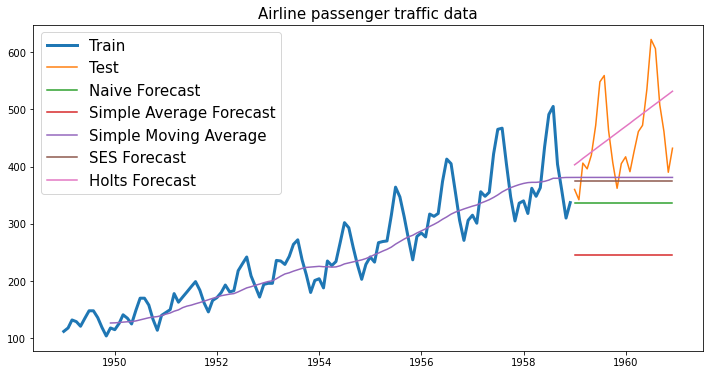

In [69]:
plt.figure(figsize=(12,6))
plt.plot(train.index, train.passengers, label='Train', linewidth=3)
plt.plot(test.index, test.passengers, label='Test')
plt.plot(y_hat_naive.index, y_hat_naive.naive_forecast, label='Naive Forecast')
plt.plot(y_hat_simple.index, y_hat_simple.simple_avg_forecast, label='Simple Average Forecast')
plt.plot(y_hat_sma.index, y_hat_sma.sma_forecast, label='Simple Moving Average')
plt.plot(y_hat_ses.index, y_hat_ses.SES_forecast, label='SES Forecast')
plt.plot(y_hat_holt.index, y_hat_holt.Holts_forecast, label='Holts Forecast')
plt.legend(loc='best', fontsize=15)
plt.title('Airline passenger traffic data', fontsize=15)
plt.show()

In [70]:
# RMSE, MAPE

from sklearn.metrics import mean_squared_error
RMSE_holt = np.sqrt(mean_squared_error(y_true=test['passengers'], y_pred=y_hat_holt['Holts_forecast']))
MAPE_holt = np.mean ( abs(test['passengers'] - y_hat_holt['Holts_forecast']) / test['passengers'] ) * 100


In [71]:
new_row = {'Method': 'Holts Exponential Smoothing', 'RMSE': RMSE_holt, 'MAPE': MAPE_holt}
df_results = df_results.append(new_row, ignore_index=True)
df_results

,Method,RMSE,MAPE
0,Naive,137.510454,23.632535
1,Simple,219.689487,44.278566
2,Simple Moving Average,103.331788,15.535497
3,Simple Exponential Smoothing,107.647071,16.487970
4,Holts Exponential Smoothing,70.968061,13.256300


## Holts Winter Exponential Smooting with Seasonal - Additive Model

In [73]:
# Import package

from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(np.array(train['passengers']), 
                            seasonal_periods=12,
                            trend = 'additive',
                            seasonal='additive')
model_fit = model.fit(optimized=True)
model_fit.params

{'smoothing_level': 0.26315789314100874,
 'smoothing_slope': 0.05162961042765743,
 'smoothing_seasonal': 0.7368421036673245,
 'damping_slope': nan,
 'initial_level': 211.55095711214224,
 'initial_slope': 1.7392241980137948,
 'initial_seasons': array([-100.1810002 ,  -94.20460323,  -80.29175713,  -83.41741831,
         -91.45886905,  -77.45075897,  -64.4831508 ,  -64.57323431,
         -76.66637207,  -93.73569904, -108.67594349,  -94.50939255]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [74]:
# Predict
y_hat_hwa = test.copy()
y_hat_hwa['HWA_forecast'] = model_fit.forecast(24)

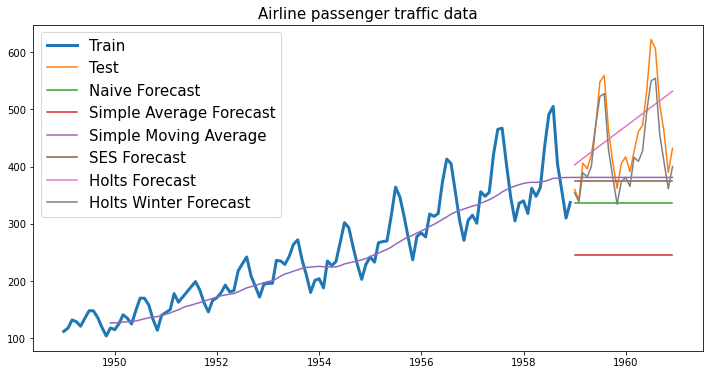

In [75]:
plt.figure(figsize=(12,6))
plt.plot(train.index, train.passengers, label='Train', linewidth=3)
plt.plot(test.index, test.passengers, label='Test')
plt.plot(y_hat_naive.index, y_hat_naive.naive_forecast, label='Naive Forecast')
plt.plot(y_hat_simple.index, y_hat_simple.simple_avg_forecast, label='Simple Average Forecast')
plt.plot(y_hat_sma.index, y_hat_sma.sma_forecast, label='Simple Moving Average')
plt.plot(y_hat_ses.index, y_hat_ses.SES_forecast, label='SES Forecast')
plt.plot(y_hat_holt.index, y_hat_holt.Holts_forecast, label='Holts Forecast')
plt.plot(y_hat_hwa.index, y_hat_hwa.HWA_forecast, label='Holts Winter Forecast')
plt.legend(loc='best', fontsize=15)
plt.title('Airline passenger traffic data', fontsize=15)
plt.show()

In [76]:
# RMSE, MAPE

from sklearn.metrics import mean_squared_error
RMSE_hwa = np.sqrt(mean_squared_error(y_true=test['passengers'], y_pred=y_hat_hwa['HWA_forecast']))
MAPE_hwa = np.mean ( abs(test['passengers'] - y_hat_hwa['HWA_forecast']) / test['passengers'] ) * 100


In [77]:
new_row = {'Method': 'Holts Winter Exponential Smoothing', 'RMSE': RMSE_hwa, 'MAPE': MAPE_hwa}
df_results = df_results.append(new_row, ignore_index=True)
df_results

,Method,RMSE,MAPE
0,Naive,137.510454,23.632535
1,Simple,219.689487,44.278566
2,Simple Moving Average,103.331788,15.535497
3,Simple Exponential Smoothing,107.647071,16.487970
4,Holts Exponential Smoothing,70.968061,13.256300
5,Holts Winter Exponential Smoothing,35.095291,6.525966


## Holts Winter Exponential Smooting with Seasonal - Multiplicative Model

In [78]:
# Import package

from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(np.array(train['passengers']), 
                            seasonal_periods=12,
                            trend = 'additive',
                            seasonal='multiplicative')
model_fit = model.fit(optimized=True)
model_fit.params

{'smoothing_level': 0.3158118670453025,
 'smoothing_slope': 0.05260642876550358,
 'smoothing_seasonal': 0.6841880551719464,
 'damping_slope': nan,
 'initial_level': 212.3993249895785,
 'initial_slope': 1.0861076931022997,
 'initial_seasons': array([0.53590491, 0.55865833, 0.61403657, 0.58356123, 0.53865597,
        0.60328662, 0.66701011, 0.66780222, 0.61192337, 0.53358502,
        0.47403319, 0.54735378]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [79]:
# Predict
y_hat_hwa_m = test.copy()
y_hat_hwa_m['HWA_forecast'] = model_fit.forecast(24)

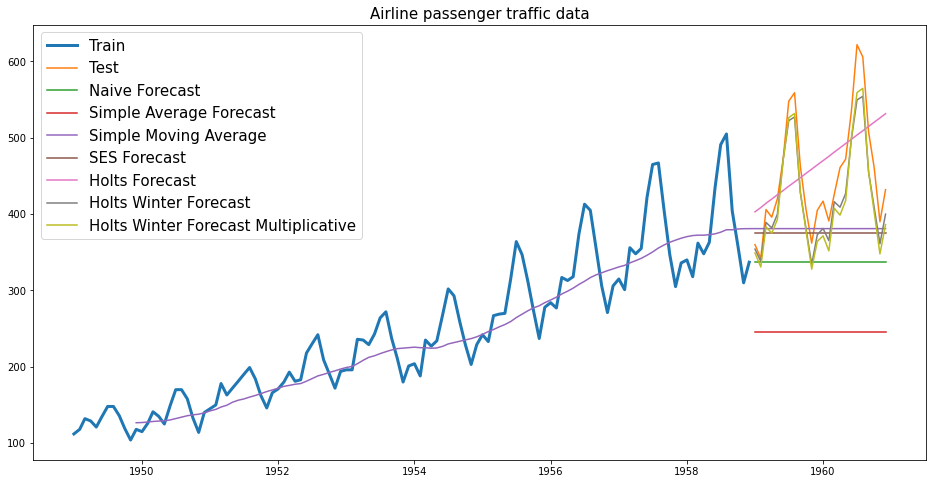

In [83]:
plt.figure(figsize=(16,8))
plt.plot(train.index, train.passengers, label='Train', linewidth=3)
plt.plot(test.index, test.passengers, label='Test')
plt.plot(y_hat_naive.index, y_hat_naive.naive_forecast, label='Naive Forecast')
plt.plot(y_hat_simple.index, y_hat_simple.simple_avg_forecast, label='Simple Average Forecast')
plt.plot(y_hat_sma.index, y_hat_sma.sma_forecast, label='Simple Moving Average')
plt.plot(y_hat_ses.index, y_hat_ses.SES_forecast, label='SES Forecast')
plt.plot(y_hat_holt.index, y_hat_holt.Holts_forecast, label='Holts Forecast')
plt.plot(y_hat_hwa.index, y_hat_hwa.HWA_forecast, label='Holts Winter Forecast')
plt.plot(y_hat_hwa_m.index, y_hat_hwa_m.HWA_forecast, label='Holts Winter Forecast Multiplicative')
plt.legend(loc='best', fontsize=15)
plt.title('Airline passenger traffic data', fontsize=15)
plt.show()

In [81]:
# RMSE, MAPE

from sklearn.metrics import mean_squared_error
RMSE_hwa_m = np.sqrt(mean_squared_error(y_true=test['passengers'], y_pred=y_hat_hwa_m['HWA_forecast']))
MAPE_hwa_m = np.mean ( abs(test['passengers'] - y_hat_hwa_m['HWA_forecast']) / test['passengers'] ) * 100


In [214]:
new_row = {'Method': 'Holts Winter Exponential Smoothing Multiplicative', 'RMSE': RMSE_hwa_m, 'MAPE': MAPE_hwa_m}
df_results = df_results.append(new_row, ignore_index=True)
df_results

,Method,RMSE,MAPE
0,Naive,137.510454,23.632535
1,Simple,219.689487,44.278566
2,Simple Moving Average,103.331788,15.535497
3,Simple Exponential Smoothing,107.647071,16.487970
4,Holts Exponential Smoothing,70.968061,13.256300
5,Holts Winter Exponential Smoothing,35.095291,6.525966
6,Holts Winter Exponential Smoothing Multiplicative,38.438018,7.673639
7,Holts Winter Exponential Smoothing Multiplicative,38.438018,7.673639


## Autoregressive Models - Stationarity Tests

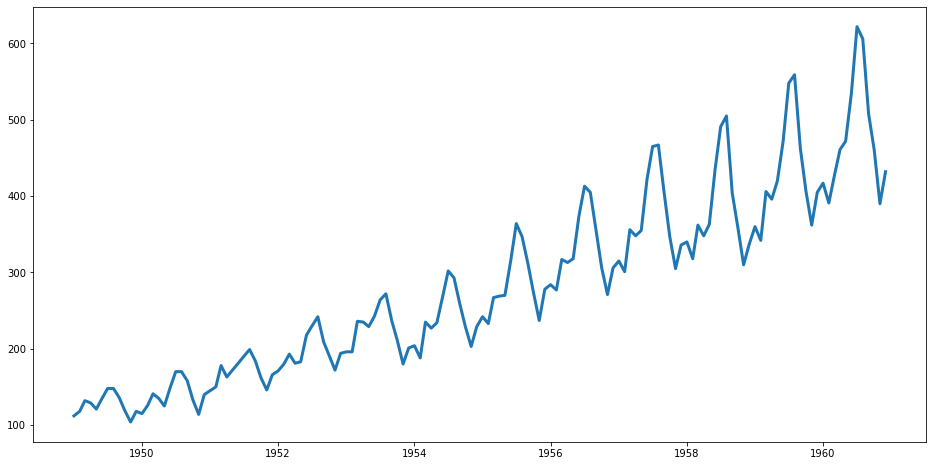

In [215]:
plt.figure(figsize=(16,8))
plt.plot(data.index, data.passengers, label='Passengers', linewidth=3)
plt.show()

### Augmented Dickey Fuller - ADF Test

In [232]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(data.passengers)
print('ADF Statistic %f' % adf_test[0])
print ('Critical value @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value %f' % adf_test[1])

ADF Statistic 0.894609
Critical value @ 0.05: -2.88
p-value 0.993020


Accept Null Hypothesis. Series is Non Stationary.

### KPSS Test

In [233]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(data.passengers)

print('KPSS Statistic %f' % kpss_test[0])
print ('Critical value @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value %f' % kpss_test[1])

KPSS Statistic 1.052050
Critical value @ 0.05: 0.46
p-value 0.010000


Reject Null Hypothesis. Series is Non Stationary.

## Autoregressive Models - Non Stationary to Stationary Conversion

### Box Cox

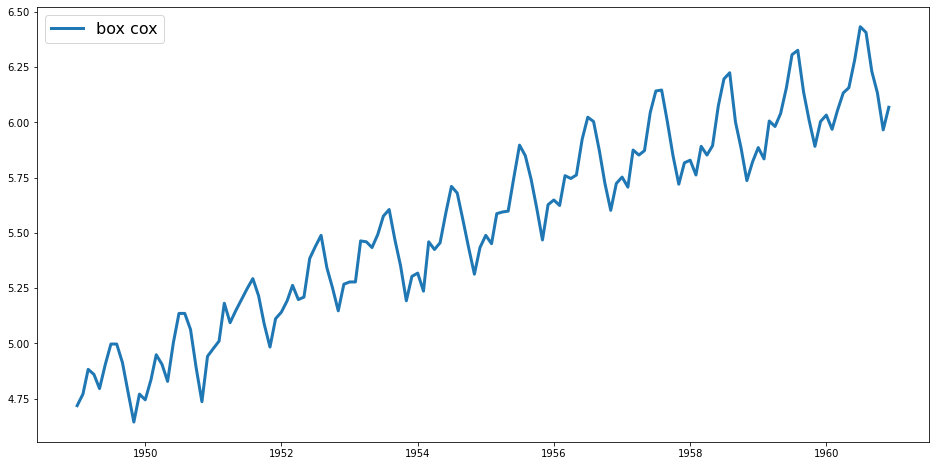

In [249]:
from scipy.stats import boxcox
data_boxcox = pd.Series(boxcox(data.passengers, lmbda=0), index = data.index)
plt.figure(figsize=(16,8))
plt.plot(data_boxcox.index, data_boxcox, label='box cox', linewidth=3)
plt.legend(loc='best', fontsize=16)
plt.show()

### Differencing

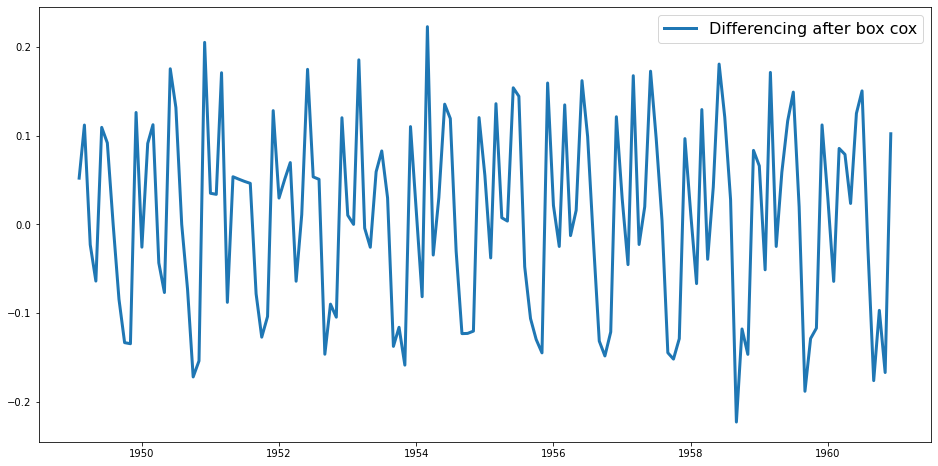

In [251]:
data_diff = pd.Series(data_boxcox - data_boxcox.shift(), index = data.index)
data_diff.dropna(inplace=True)
plt.figure(figsize=(16,8))
plt.plot(data_diff.index, data_diff, label='Differencing after box cox', linewidth=3)
plt.legend(loc='best', fontsize=16)
plt.show()

In [254]:
from statsmodels.tsa.stattools import adfuller
adf_test_diff = adfuller(data_diff)
print('ADF Statistic %f' % adf_test_diff[0])
print ('Critical value @ 0.05: %.2f' % adf_test_diff[4]['5%'])
print('p-value %f' % adf_test_diff[1])

ADF Statistic -3.290114
Critical value @ 0.05: -2.88
p-value 0.015326


Reject Null Hypothesis. Series is Stationary.

In [255]:
from statsmodels.tsa.stattools import kpss
kpss_test_diff = kpss(data_diff)
print('KPSS Statistic %f' % kpss_test_diff[0])
print ('Critical value @ 0.05: %.2f' % kpss_test_diff[3]['5%'])
print('p-value %f' % kpss_test_diff[1])

KPSS Statistic 0.101871
Critical value @ 0.05: 0.46
p-value 0.100000


Accept Null Hypothesis. Series is Stationary.

## Auto Correlation Function Plot

### ACF

<Figure size 1152x576 with 0 Axes>

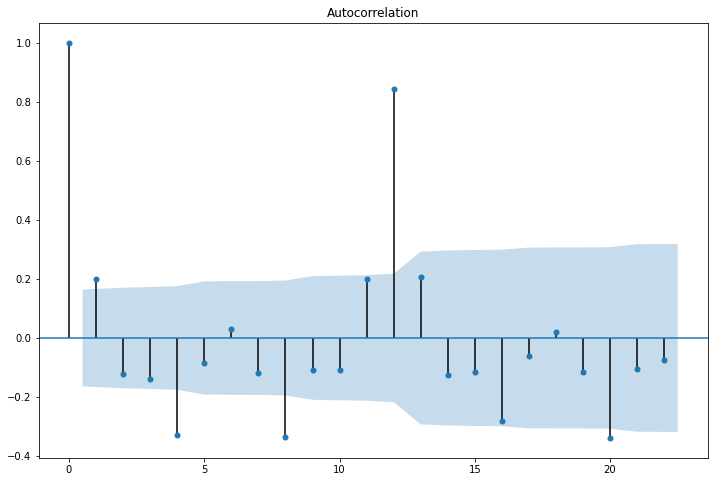

In [259]:
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(16,8))
plot_acf(data_diff)
plt.show()

### PACF

<Figure size 1152x576 with 0 Axes>

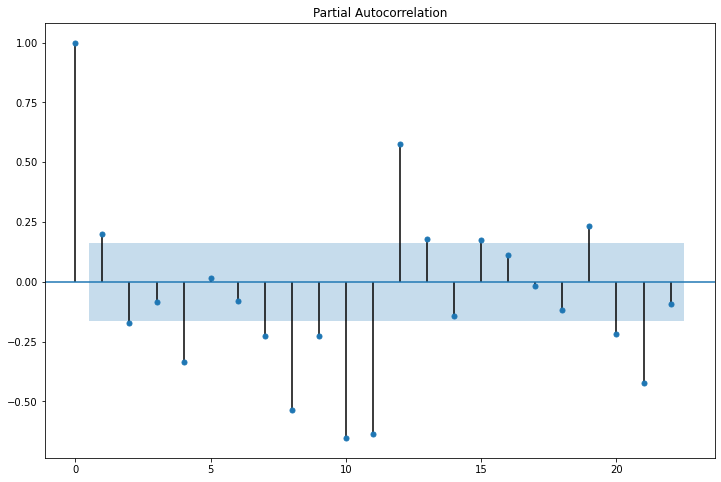

In [260]:
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(16,8))
plot_pacf(data_diff)
plt.show()

### Split Training Data

In [263]:
# Split into train test

train_len = 120

train_b = data_boxcox[:train_len]
test_b = data_boxcox[train_len:]

train_d = data_diff[:train_len-1]
test_d = data_diff[train_len-1:]

## AutoRegression Method (AR)

In [266]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train_d, order=(1,0,0))
model_fit = model.fit()
print (model_fit.params)

const      0.009477
ar.L1.y    0.183116
dtype: float64


### Recover Original Pred

In [271]:
y_hat_ar = data_diff.copy()
y_hat_ar['ar_forecast_boxcox_diff'] = model_fit.predict(data_diff.index.min(), data_diff.index.max())
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox_diff'].cumsum() # Opp of Diffrencing
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox'].add(data_boxcox[0]) # First row addition
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])

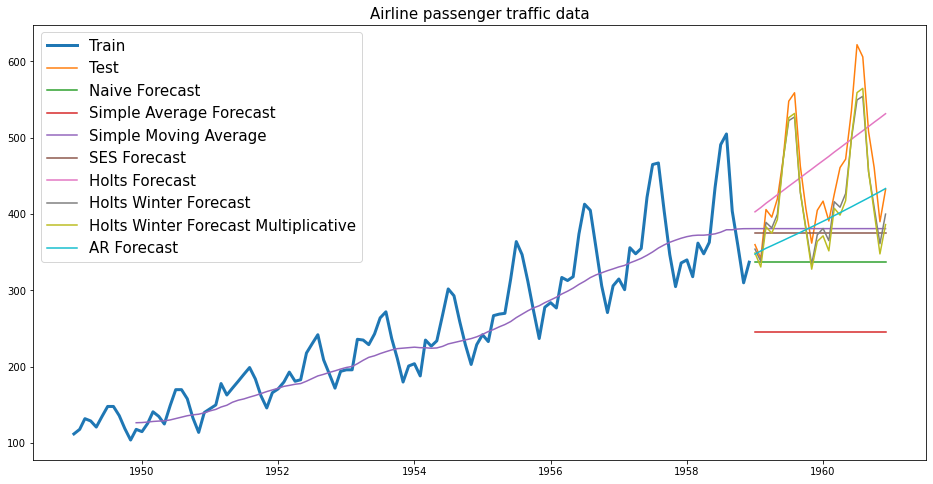

In [273]:
plt.figure(figsize=(16,8))
plt.plot(train.index, train.passengers, label='Train', linewidth=3)
plt.plot(test.index, test.passengers, label='Test')
plt.plot(y_hat_naive.index, y_hat_naive.naive_forecast, label='Naive Forecast')
plt.plot(y_hat_simple.index, y_hat_simple.simple_avg_forecast, label='Simple Average Forecast')
plt.plot(y_hat_sma.index, y_hat_sma.sma_forecast, label='Simple Moving Average')
plt.plot(y_hat_ses.index, y_hat_ses.SES_forecast, label='SES Forecast')
plt.plot(y_hat_holt.index, y_hat_holt.Holts_forecast, label='Holts Forecast')
plt.plot(y_hat_hwa.index, y_hat_hwa.HWA_forecast, label='Holts Winter Forecast')
plt.plot(y_hat_hwa_m.index, y_hat_hwa_m.HWA_forecast, label='Holts Winter Forecast Multiplicative')
plt.plot(y_hat_ar.ar_forecast[test.index.min():], label='AR Forecast')
plt.legend(loc='best', fontsize=15)
plt.title('Airline passenger traffic data', fontsize=15)
plt.show()

In [275]:
# RMSE, MAPE

from sklearn.metrics import mean_squared_error
RMSE_AR = np.sqrt(mean_squared_error(y_true=test['passengers'], y_pred=y_hat_ar.ar_forecast[test.index.min():]))
MAPE_AR = np.mean ( abs(test['passengers'] - y_hat_ar.ar_forecast[test.index.min():]) / test['passengers'] ) * 100

new_row = {'Method': 'Auto Regression Method', 'RMSE': RMSE_AR, 'MAPE': MAPE_AR}
df_results = df_results.append(new_row, ignore_index=True)
df_results

,Method,RMSE,MAPE
0,Naive,137.510454,23.632535
1,Simple,219.689487,44.278566
2,Simple Moving Average,103.331788,15.535497
3,Simple Exponential Smoothing,107.647071,16.487970
4,Holts Exponential Smoothing,70.968061,13.256300
5,Holts Winter Exponential Smoothing,35.095291,6.525966
6,Holts Winter Exponential Smoothing Multiplicative,38.438018,7.673639
7,Holts Winter Exponential Smoothing Multiplicative,38.438018,7.673639
8,Auto Regression Method,93.386155,13.765663


## Moving Average Method (MA)

In [276]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train_d, order=(0,0,1))
model_fit = model.fit()
print (model_fit.params)

const      0.009538
ma.L1.y    0.266103
dtype: float64


### Recover Original Pred

In [280]:
y_hat_ma = data_diff.copy()
y_hat_ma['ma_forecast_boxcox_diff'] = model_fit.predict(data_diff.index.min(), data_diff.index.max())
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox_diff'].cumsum() # Opp of Differencing
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox'].add(data_boxcox[0]) # First row addition
y_hat_ma['ma_forecast'] = np.exp(y_hat_ma['ma_forecast_boxcox'])

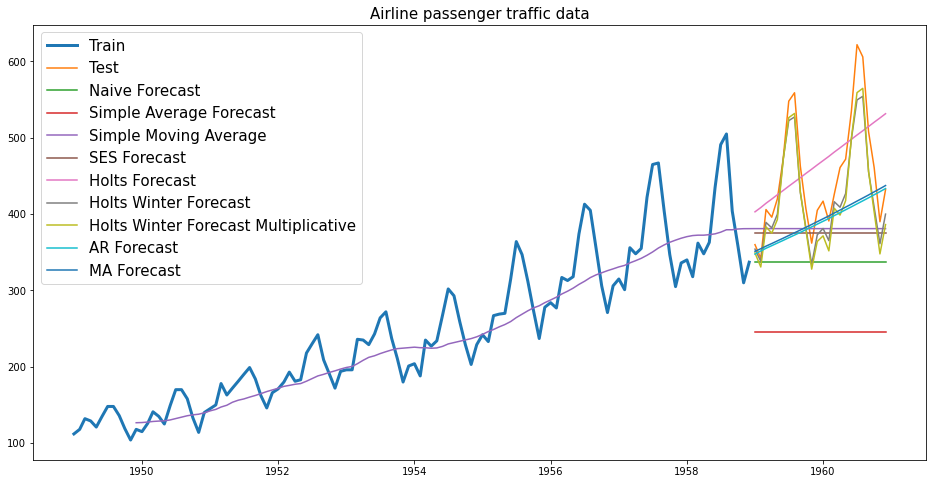

In [281]:
plt.figure(figsize=(16,8))
plt.plot(train.index, train.passengers, label='Train', linewidth=3)
plt.plot(test.index, test.passengers, label='Test')
plt.plot(y_hat_naive.index, y_hat_naive.naive_forecast, label='Naive Forecast')
plt.plot(y_hat_simple.index, y_hat_simple.simple_avg_forecast, label='Simple Average Forecast')
plt.plot(y_hat_sma.index, y_hat_sma.sma_forecast, label='Simple Moving Average')
plt.plot(y_hat_ses.index, y_hat_ses.SES_forecast, label='SES Forecast')
plt.plot(y_hat_holt.index, y_hat_holt.Holts_forecast, label='Holts Forecast')
plt.plot(y_hat_hwa.index, y_hat_hwa.HWA_forecast, label='Holts Winter Forecast')
plt.plot(y_hat_hwa_m.index, y_hat_hwa_m.HWA_forecast, label='Holts Winter Forecast Multiplicative')
plt.plot(y_hat_ar.ar_forecast[test.index.min():], label='AR Forecast')
plt.plot(y_hat_ma.ma_forecast[test.index.min():], label='MA Forecast')
plt.legend(loc='best', fontsize=15)
plt.title('Airline passenger traffic data', fontsize=15)
plt.show()

In [282]:
# RMSE, MAPE

from sklearn.metrics import mean_squared_error
RMSE_MA = np.sqrt(mean_squared_error(y_true=test['passengers'], y_pred=y_hat_ma.ma_forecast[test.index.min():]))
MAPE_MA = np.mean ( abs(test['passengers'] - y_hat_ma.ma_forecast[test.index.min():]) / test['passengers'] ) * 100

new_row = {'Method': 'Moving Average Method', 'RMSE': RMSE_MA, 'MAPE': MAPE_MA}
df_results = df_results.append(new_row, ignore_index=True)
df_results

,Method,RMSE,MAPE
0,Naive,137.510454,23.632535
1,Simple,219.689487,44.278566
2,Simple Moving Average,103.331788,15.535497
3,Simple Exponential Smoothing,107.647071,16.487970
4,Holts Exponential Smoothing,70.968061,13.256300
5,Holts Winter Exponential Smoothing,35.095291,6.525966
6,Holts Winter Exponential Smoothing Multiplicative,38.438018,7.673639
7,Holts Winter Exponential Smoothing Multiplicative,38.438018,7.673639
8,Auto Regression Method,93.386155,13.765663
9,Moving Average Method,91.205536,13.389987


## ARMA

In [285]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train_d, order=(1,0,1))
model_fit = model.fit()
print (model_fit.params)

const      0.009624
ar.L1.y   -0.527115
ma.L1.y    0.798281
dtype: float64


In [307]:
y_hat_arma = data_diff.copy()
y_hat_arma['arma_forecast_boxcox_diff'] = model_fit.predict(data_diff.index.min(), data_diff.index.max())
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox_diff'].cumsum()
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox'].add(data_boxcox[0])
y_hat_arma['arma_forecast'] = np.exp(y_hat_arma['arma_forecast_boxcox'])

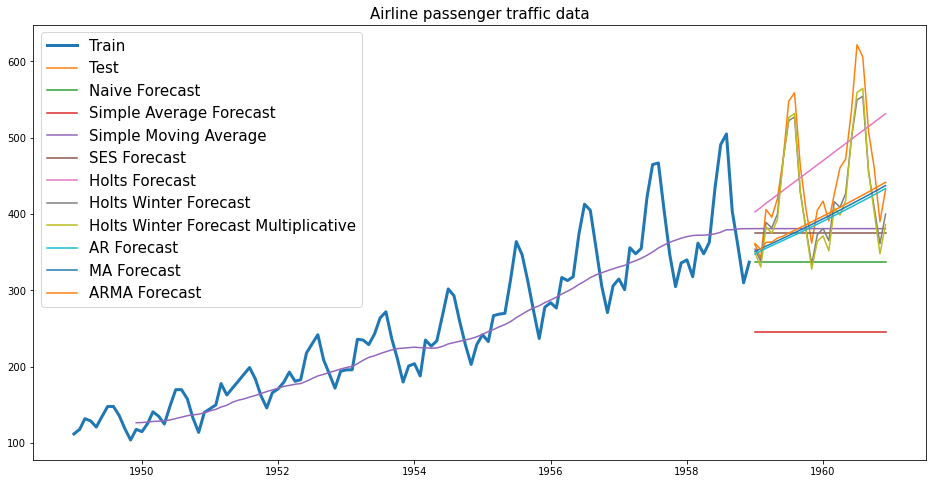

In [308]:
plt.figure(figsize=(16,8))
plt.plot(train.index, train.passengers, label='Train', linewidth=3)
plt.plot(test.index, test.passengers, label='Test')
plt.plot(y_hat_naive.index, y_hat_naive.naive_forecast, label='Naive Forecast')
plt.plot(y_hat_simple.index, y_hat_simple.simple_avg_forecast, label='Simple Average Forecast')
plt.plot(y_hat_sma.index, y_hat_sma.sma_forecast, label='Simple Moving Average')
plt.plot(y_hat_ses.index, y_hat_ses.SES_forecast, label='SES Forecast')
plt.plot(y_hat_holt.index, y_hat_holt.Holts_forecast, label='Holts Forecast')
plt.plot(y_hat_hwa.index, y_hat_hwa.HWA_forecast, label='Holts Winter Forecast')
plt.plot(y_hat_hwa_m.index, y_hat_hwa_m.HWA_forecast, label='Holts Winter Forecast Multiplicative')
plt.plot(y_hat_ar.ar_forecast[test.index.min():], label='AR Forecast')
plt.plot(y_hat_ma.ma_forecast[test.index.min():], label='MA Forecast')
plt.plot(y_hat_arma.arma_forecast[test.index.min():], label='ARMA Forecast')
plt.legend(loc='best', fontsize=15)
plt.title('Airline passenger traffic data', fontsize=15)
plt.show()

In [289]:
# RMSE, MAPE

from sklearn.metrics import mean_squared_error
RMSE_ARMA = np.sqrt(mean_squared_error(y_true=test['passengers'], y_pred=y_hat_arma.arma_forecast[test.index.min():]))
MAPE_ARMA = np.mean ( abs(test['passengers'] - y_hat_arma.arma_forecast[test.index.min():]) / test['passengers'] ) * 100

new_row = {'Method': 'ARMA Method', 'RMSE': RMSE_ARMA, 'MAPE': MAPE_ARMA}
df_results = df_results.append(new_row, ignore_index=True)
df_results

,Method,RMSE,MAPE
0,Naive,137.510454,23.632535
1,Simple,219.689487,44.278566
2,Simple Moving Average,103.331788,15.535497
3,Simple Exponential Smoothing,107.647071,16.487970
4,Holts Exponential Smoothing,70.968061,13.256300
5,Holts Winter Exponential Smoothing,35.095291,6.525966
6,Holts Winter Exponential Smoothing Multiplicative,38.438018,7.673639
7,Holts Winter Exponential Smoothing Multiplicative,38.438018,7.673639
8,Auto Regression Method,93.386155,13.765663
9,Moving Average Method,91.205536,13.389987


## ARIMA

In [301]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train_b, order=(1,1,1)) # Pass Training Data After BoxCox
model_fit = model.fit()
print (model_fit.params)

const        0.009624
ar.L1.D.y   -0.527115
ma.L1.D.y    0.798281
dtype: float64


In [306]:
y_hat_arima = data_diff.copy()
y_hat_arima['arima_forecast_boxcox_diff'] = model_fit.predict(data_diff.index.min(), data_diff.index.max())
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox_diff'].cumsum()
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox'].add(data_boxcox[0])
y_hat_arima['arima_forecast'] = np.exp(y_hat_arima['arima_forecast_boxcox'])

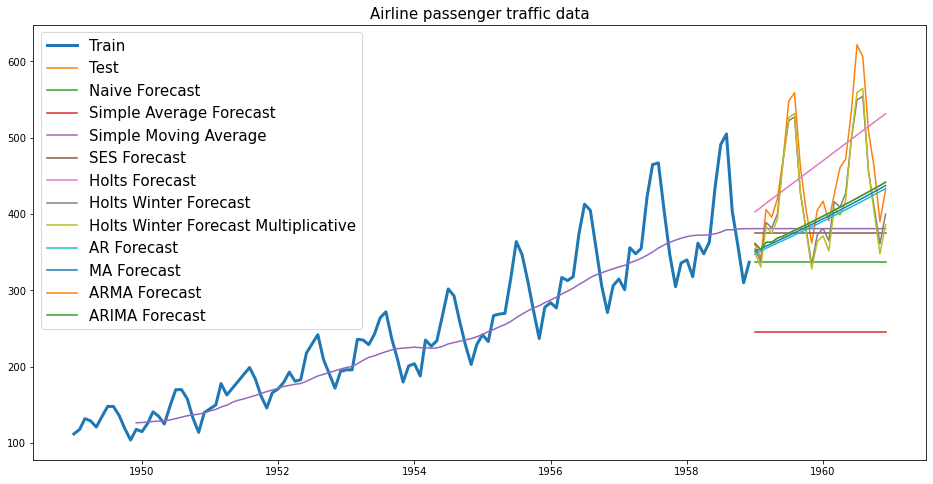

In [309]:
plt.figure(figsize=(16,8))
plt.plot(train.index, train.passengers, label='Train', linewidth=3)
plt.plot(test.index, test.passengers, label='Test')
plt.plot(y_hat_naive.index, y_hat_naive.naive_forecast, label='Naive Forecast')
plt.plot(y_hat_simple.index, y_hat_simple.simple_avg_forecast, label='Simple Average Forecast')
plt.plot(y_hat_sma.index, y_hat_sma.sma_forecast, label='Simple Moving Average')
plt.plot(y_hat_ses.index, y_hat_ses.SES_forecast, label='SES Forecast')
plt.plot(y_hat_holt.index, y_hat_holt.Holts_forecast, label='Holts Forecast')
plt.plot(y_hat_hwa.index, y_hat_hwa.HWA_forecast, label='Holts Winter Forecast')
plt.plot(y_hat_hwa_m.index, y_hat_hwa_m.HWA_forecast, label='Holts Winter Forecast Multiplicative')
plt.plot(y_hat_ar.ar_forecast[test.index.min():], label='AR Forecast')
plt.plot(y_hat_ma.ma_forecast[test.index.min():], label='MA Forecast')
plt.plot(y_hat_arma.arma_forecast[test.index.min():], label='ARMA Forecast')
plt.plot(y_hat_arima.arima_forecast[test.index.min():], label='ARIMA Forecast')
plt.legend(loc='best', fontsize=15)
plt.title('Airline passenger traffic data', fontsize=15)
plt.show()

In [310]:
# RMSE, MAPE

from sklearn.metrics import mean_squared_error
RMSE_ARIMA = np.sqrt(mean_squared_error(y_true=test['passengers'], y_pred=y_hat_arima.arima_forecast[test.index.min():]))
MAPE_ARIMA = np.mean ( abs(test['passengers'] - y_hat_arima.arima_forecast[test.index.min():]) / test['passengers'] ) * 100

new_row = {'Method': 'ARIMA Method', 'RMSE': RMSE_ARIMA, 'MAPE': MAPE_ARIMA}
df_results = df_results.append(new_row, ignore_index=True)
df_results

,Method,RMSE,MAPE
0,Naive,137.510454,23.632535
1,Simple,219.689487,44.278566
2,Simple Moving Average,103.331788,15.535497
3,Simple Exponential Smoothing,107.647071,16.487970
4,Holts Exponential Smoothing,70.968061,13.256300
5,Holts Winter Exponential Smoothing,35.095291,6.525966
6,Holts Winter Exponential Smoothing Multiplicative,38.438018,7.673639
7,Holts Winter Exponential Smoothing Multiplicative,38.438018,7.673639
8,Auto Regression Method,93.386155,13.765663
9,Moving Average Method,91.205536,13.389987


## Seasonal ARIMA (SARIMA)

In [314]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train_b, order=(1,1,1), seasonal_order = (1,1,1,12))
model_fit = model.fit()
print (model_fit.params)

ar.L1       0.390127
ma.L1      -0.681153
ar.S.L12   -0.041181
ma.S.L12   -0.516703
sigma2      0.001407
dtype: float64


In [315]:
y_hat_sarima = data_diff.copy()
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_diff.index.min(), data_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

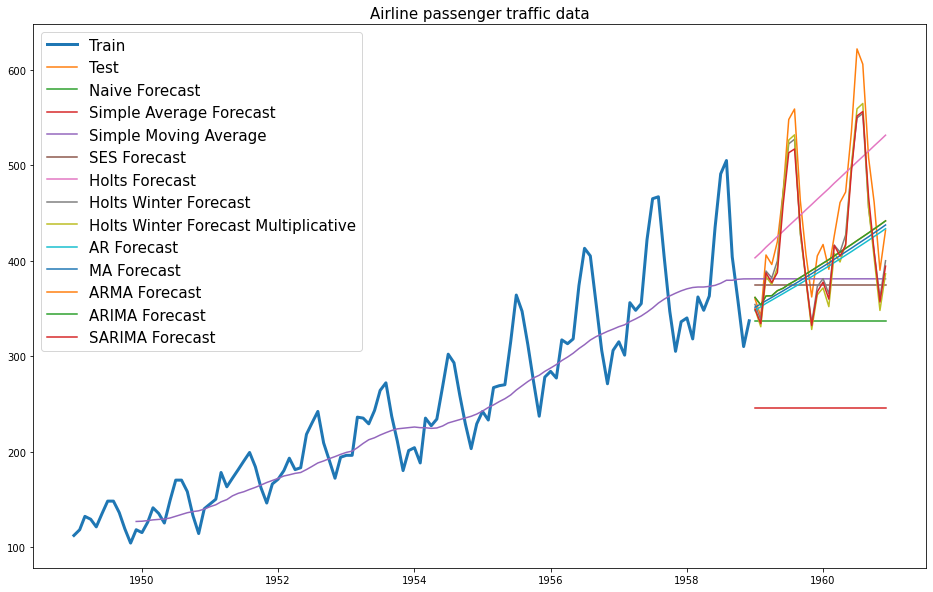

In [318]:
plt.figure(figsize=(16,10))
plt.plot(train.index, train.passengers, label='Train', linewidth=3)
plt.plot(test.index, test.passengers, label='Test')
plt.plot(y_hat_naive.index, y_hat_naive.naive_forecast, label='Naive Forecast')
plt.plot(y_hat_simple.index, y_hat_simple.simple_avg_forecast, label='Simple Average Forecast')
plt.plot(y_hat_sma.index, y_hat_sma.sma_forecast, label='Simple Moving Average')
plt.plot(y_hat_ses.index, y_hat_ses.SES_forecast, label='SES Forecast')
plt.plot(y_hat_holt.index, y_hat_holt.Holts_forecast, label='Holts Forecast')
plt.plot(y_hat_hwa.index, y_hat_hwa.HWA_forecast, label='Holts Winter Forecast')
plt.plot(y_hat_hwa_m.index, y_hat_hwa_m.HWA_forecast, label='Holts Winter Forecast Multiplicative')
plt.plot(y_hat_ar.ar_forecast[test.index.min():], label='AR Forecast')
plt.plot(y_hat_ma.ma_forecast[test.index.min():], label='MA Forecast')
plt.plot(y_hat_arma.arma_forecast[test.index.min():], label='ARMA Forecast')
plt.plot(y_hat_arima.arima_forecast[test.index.min():], label='ARIMA Forecast')
plt.plot(y_hat_sarima.sarima_forecast[test.index.min():], label='SARIMA Forecast')
plt.legend(loc='best', fontsize=15)
plt.title('Airline passenger traffic data', fontsize=15)
plt.show()

In [317]:
# RMSE, MAPE

from sklearn.metrics import mean_squared_error
RMSE_SARIMA = np.sqrt(mean_squared_error(y_true=test['passengers'], y_pred=y_hat_sarima.sarima_forecast[test.index.min():]))
MAPE_SARIMA = np.mean ( abs(test['passengers'] - y_hat_sarima.sarima_forecast[test.index.min():]) / test['passengers'] ) * 100

new_row = {'Method': 'SARIMA Method', 'RMSE': RMSE_SARIMA, 'MAPE': MAPE_SARIMA}
df_results = df_results.append(new_row, ignore_index=True)
df_results

,Method,RMSE,MAPE
0,Naive,137.510454,23.632535
1,Simple,219.689487,44.278566
2,Simple Moving Average,103.331788,15.535497
3,Simple Exponential Smoothing,107.647071,16.487970
4,Holts Exponential Smoothing,70.968061,13.256300
5,Holts Winter Exponential Smoothing,35.095291,6.525966
6,Holts Winter Exponential Smoothing Multiplicative,38.438018,7.673639
7,Holts Winter Exponential Smoothing Multiplicative,38.438018,7.673639
8,Auto Regression Method,93.386155,13.765663
9,Moving Average Method,91.205536,13.389987


## Seasonal Auto Regressive Integrated Moving Average Exogenous Variables (SARIMAX)

In [321]:
promo = pd.read_csv('promotion.csv', header=None)
promo.columns = ['Month', 'Event']
promo['Month'] = pd.to_datetime(promo['Month'], format = '%Y-%m')
promo = promo.set_index('Month')
promo.head()

,Event
Month,
1949-01-01,0
1949-02-01,0
1949-03-01,0
1949-04-01,0
1949-05-01,0


In [322]:
# Split into train test

train_len = 120

promo_train = promo[:train_len]
promo_test = promo[train_len:]

In [323]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train_b, order=(1,1,1), seasonal_order=(1,1,1,12), exog = promo_train)
model_fit = model.fit()
print(model_fit.params)

Event       0.034334
ar.L1       0.486301
ma.L1      -0.747780
ar.S.L12   -0.062348
ma.S.L12   -0.560447
sigma2      0.001334
dtype: float64


In [324]:
y_hat_sarimax = data_diff.copy()
y_hat_sarimax['sarimax_forecast_boxcox'] = model_fit.predict(data_diff.index.min(), data_diff.index.max(), exog = promo_test)
y_hat_sarimax['sarimax_forecast'] = np.exp(y_hat_sarimax['sarimax_forecast_boxcox'])

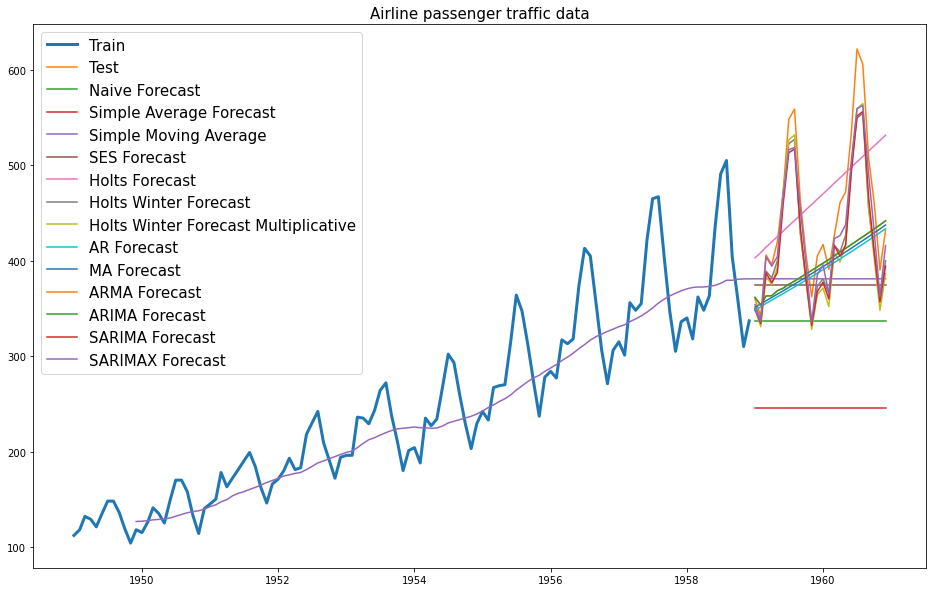

In [325]:
plt.figure(figsize=(16,10))
plt.plot(train.index, train.passengers, label='Train', linewidth=3)
plt.plot(test.index, test.passengers, label='Test')
plt.plot(y_hat_naive.index, y_hat_naive.naive_forecast, label='Naive Forecast')
plt.plot(y_hat_simple.index, y_hat_simple.simple_avg_forecast, label='Simple Average Forecast')
plt.plot(y_hat_sma.index, y_hat_sma.sma_forecast, label='Simple Moving Average')
plt.plot(y_hat_ses.index, y_hat_ses.SES_forecast, label='SES Forecast')
plt.plot(y_hat_holt.index, y_hat_holt.Holts_forecast, label='Holts Forecast')
plt.plot(y_hat_hwa.index, y_hat_hwa.HWA_forecast, label='Holts Winter Forecast')
plt.plot(y_hat_hwa_m.index, y_hat_hwa_m.HWA_forecast, label='Holts Winter Forecast Multiplicative')
plt.plot(y_hat_ar.ar_forecast[test.index.min():], label='AR Forecast')
plt.plot(y_hat_ma.ma_forecast[test.index.min():], label='MA Forecast')
plt.plot(y_hat_arma.arma_forecast[test.index.min():], label='ARMA Forecast')
plt.plot(y_hat_arima.arima_forecast[test.index.min():], label='ARIMA Forecast')
plt.plot(y_hat_sarima.sarima_forecast[test.index.min():], label='SARIMA Forecast')
plt.plot(y_hat_sarimax.sarimax_forecast[test.index.min():], label='SARIMAX Forecast')
plt.legend(loc='best', fontsize=15)
plt.title('Airline passenger traffic data', fontsize=15)
plt.show()

In [327]:
# RMSE, MAPE

from sklearn.metrics import mean_squared_error
RMSE_SARIMAX = np.sqrt(mean_squared_error(y_true=test['passengers'], y_pred=y_hat_sarimax.sarimax_forecast[test.index.min():]))
MAPE_SARIMAX = np.mean ( abs(test['passengers'] - y_hat_sarimax.sarimax_forecast[test.index.min():]) / test['passengers'] ) * 100

new_row = {'Method': 'SARIMAX Method', 'RMSE': RMSE_SARIMAX, 'MAPE': MAPE_SARIMAX}
df_results = df_results.append(new_row, ignore_index=True)
df_results

,Method,RMSE,MAPE
0,Naive,137.510454,23.632535
1,Simple,219.689487,44.278566
2,Simple Moving Average,103.331788,15.535497
3,Simple Exponential Smoothing,107.647071,16.487970
4,Holts Exponential Smoothing,70.968061,13.256300
5,Holts Winter Exponential Smoothing,35.095291,6.525966
6,Holts Winter Exponential Smoothing Multiplicative,38.438018,7.673639
7,Holts Winter Exponential Smoothing Multiplicative,38.438018,7.673639
8,Auto Regression Method,93.386155,13.765663
9,Moving Average Method,91.205536,13.389987


# MetRail dataset

In [31]:
df = pd.read_csv('Metrail+dataset.csv')
df['Month'] = pd.to_datetime(df.Month, format='%b-%y')
df = df.set_index('Month')
df.head()

,Travellers('000)
Month,
1991-01-01,1724.0
1991-02-01,1638.0
1991-03-01,1987.0
1991-04-01,1825.0
1991-05-01,NaN


#### Imputate with last observed value

In [32]:
# Methods: method ='pad' or method='ffill' of fillna() 

df = df.assign(Travellers_Last_Observed_Imputate = df['Travellers(\'000)'].fillna(method ='pad'))

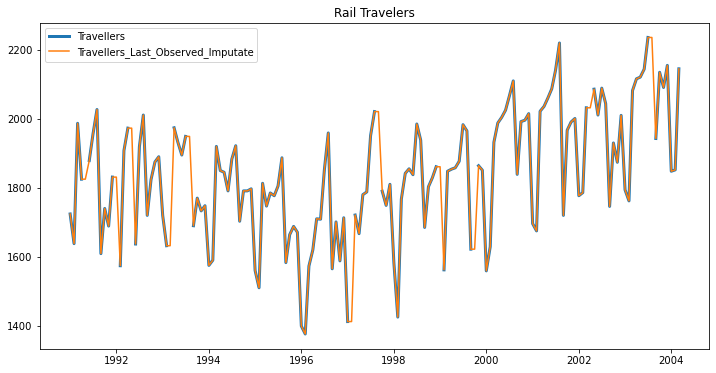

In [33]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Travellers(\'000)'], label='Travellers', linewidth = 3)
plt.plot(df.index, df['Travellers_Last_Observed_Imputate'], label='Travellers_Last_Observed_Imputate')
plt.legend(loc='best')
plt.title('Rail Travelers')
plt.show()

In [34]:
round(df['Travellers_Last_Observed_Imputate'].mean(),2)

1838.69

#### Imputate with next observed value

In [35]:
# Methods: method ='bfill'

df = df.assign(Travellers_Next_Observed_Imputate = df['Travellers(\'000)'].fillna(method ='bfill'))

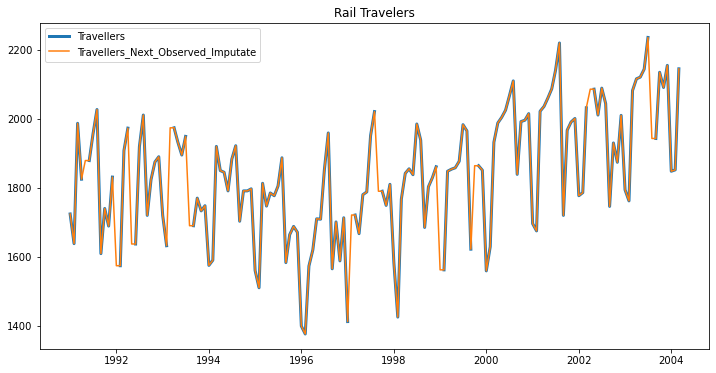

In [36]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Travellers(\'000)'], label='Travellers', linewidth = 3)
plt.plot(df.index, df['Travellers_Next_Observed_Imputate'], label='Travellers_Next_Observed_Imputate')
plt.legend(loc='best')
plt.title('Rail Travelers')
plt.show()

In [37]:
round(df['Travellers_Next_Observed_Imputate'].mean(),2)

1834.45

#### Imputate with linear interpolation

In [38]:
# Methods: method ='bfill'

df = df.assign(Travellers_Linear_Interpolation_Imputate = df['Travellers(\'000)'].interpolate(method ='linear'))

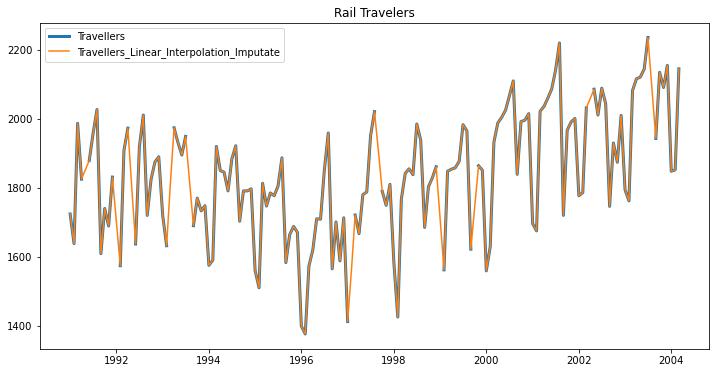

In [39]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Travellers(\'000)'], label='Travellers', linewidth = 3)
plt.plot(df.index, df['Travellers_Linear_Interpolation_Imputate'], label='Travellers_Linear_Interpolation_Imputate')
plt.legend(loc='best')
plt.title('Rail Travelers')
plt.show()

In [40]:
round(df['Travellers_Linear_Interpolation_Imputate'].mean(),2)

1836.57

# Exchange Rate dataset

In [41]:
df_rate = pd.read_csv('exchange-rate-twi.csv')
df_rate.head()

,Month,Exchange Rate TWI
0,1,100.0
1,2,99.6
2,3,99.4
3,4,99.1
4,5,99.2


In [42]:
# Split into train test
train_len_1 = 212
df_rate_train = df_rate[:train_len_1]
df_rate_test = df_rate[train_len_1:]

### Simple Average

In [43]:
df_rate_train['Exchange Rate TWI'].mean()

88.32547169811328

In [44]:
y_hat_simple_1 = df_rate_test.copy()
y_hat_simple_1['simple_avg_forecast'] = df_rate_train['Exchange Rate TWI'].mean()

### Naive

In [45]:
df_rate_train['Exchange Rate TWI'][train_len_1-1]

52.0

In [46]:
y_hat_naive_1 = df_rate_test.copy()
y_hat_naive_1['naive_method'] = df_rate_train['Exchange Rate TWI'][train_len_1-1]

### Simple Moving Average

In [47]:
y_hat_sma_1 = df_rate.copy()
ma_win_1 = 12
y_hat_sma_1['simple_moving_avg'] = df_rate['Exchange Rate TWI'].rolling(ma_win_1).mean()
y_hat_sma_1['simple_moving_avg'][train_len_1:] = y_hat_sma_1['simple_moving_avg'][train_len_1-1]

In [48]:
y_hat_sma_2 = df_rate.copy()
ma_win_2 = 6
y_hat_sma_2['simple_moving_avg'] = df_rate['Exchange Rate TWI'].rolling(ma_win_2).mean()
y_hat_sma_2['simple_moving_avg'][train_len_1:] = y_hat_sma_2['simple_moving_avg'][train_len_1-1]

In [49]:
y_hat_sma_3 = df_rate.copy()
ma_win_3 = 3
y_hat_sma_3['simple_moving_avg'] = df_rate['Exchange Rate TWI'].rolling(ma_win_3).mean()
y_hat_sma_3['simple_moving_avg'][train_len_1:] = y_hat_sma_3['simple_moving_avg'][train_len_1-1]

### Plot

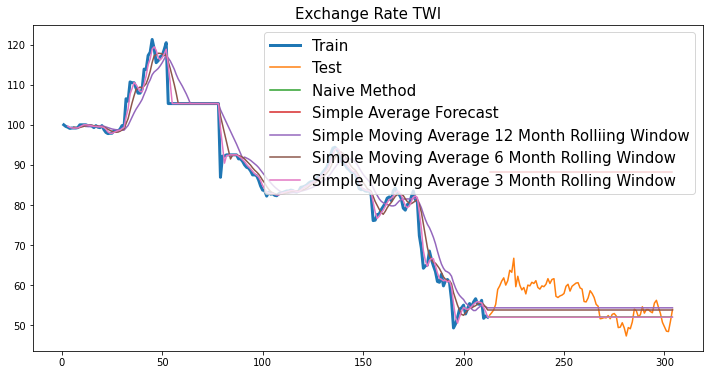

In [50]:
plt.figure(figsize=(12,6))
plt.plot(df_rate_train.Month, df_rate_train['Exchange Rate TWI'], label='Train', linewidth=3)
plt.plot(df_rate_test.Month, df_rate_test['Exchange Rate TWI'], label='Test')
plt.plot(y_hat_naive_1.Month, y_hat_naive_1.naive_method, label='Naive Method')
plt.plot(y_hat_simple_1.Month, y_hat_simple_1.simple_avg_forecast, label='Simple Average Forecast')
plt.plot(y_hat_sma_1.Month, y_hat_sma_1.simple_moving_avg, label='Simple Moving Average 12 Month Rolliing Window')
plt.plot(y_hat_sma_2.Month, y_hat_sma_2.simple_moving_avg, label='Simple Moving Average 6 Month Rolling Window')
plt.plot(y_hat_sma_3.Month, y_hat_sma_3.simple_moving_avg, label='Simple Moving Average 3 Month Rolling Window')
plt.legend(loc='best', fontsize=15)
plt.title('Exchange Rate TWI', fontsize=15)
plt.show()

### RMSE and MAPE

In [51]:
from sklearn.metrics import mean_squared_error

RMSE_simple_1 = np.sqrt(mean_squared_error(y_true=df_rate_test['Exchange Rate TWI'], 
                                           y_pred= y_hat_simple_1['simple_avg_forecast']))
RMSE_naive_1 = np.sqrt(mean_squared_error(y_true = df_rate_test['Exchange Rate TWI'],
                                         y_pred=y_hat_naive_1['naive_method']))
RMSE_sma_1 = np.sqrt(mean_squared_error(y_true = df_rate_test['Exchange Rate TWI'],
                                         y_pred=y_hat_sma_1['simple_moving_avg'][train_len_1:]))
RMSE_sma_2 = np.sqrt(mean_squared_error(y_true = df_rate_test['Exchange Rate TWI'],
                                         y_pred=y_hat_sma_2['simple_moving_avg'][train_len_1:]))
RMSE_sma_3 = np.sqrt(mean_squared_error(y_true = df_rate_test['Exchange Rate TWI'],
                                         y_pred=y_hat_sma_3['simple_moving_avg'][train_len_1:]))

MAPE_simple_1 = np.mean ( abs( (df_rate_test['Exchange Rate TWI']-y_hat_simple_1['simple_avg_forecast'])/df_rate_test['Exchange Rate TWI'] ))

MAPE_naive_1 = np.mean ( abs( (df_rate_test['Exchange Rate TWI']-y_hat_naive_1['naive_method'])/df_rate_test['Exchange Rate TWI'] ))

MAPE_sma_1 = np.mean ( abs( (df_rate_test['Exchange Rate TWI']-y_hat_sma_1['simple_moving_avg'][train_len_1:])/df_rate_test['Exchange Rate TWI'] ))

MAPE_sma_2 = np.mean ( abs( (df_rate_test['Exchange Rate TWI']-y_hat_sma_2['simple_moving_avg'][train_len_1:])/df_rate_test['Exchange Rate TWI'] ))

MAPE_sma_3 = np.mean ( abs( (df_rate_test['Exchange Rate TWI']-y_hat_sma_3['simple_moving_avg'][train_len_1:])/df_rate_test['Exchange Rate TWI'] ))


df_results_1 = pd.DataFrame()
df_results_1['Method'] = ['Naive', 'Simple', 'Moving 12 Month', 'Moving 6 Month', 'Moving 3 Month']
df_results_1['RMSE'] = [RMSE_naive_1, RMSE_simple_1, RMSE_sma_1, RMSE_sma_2, RMSE_sma_3]
df_results_1['MAPE'] = [MAPE_naive_1, MAPE_simple_1, MAPE_sma_1, MAPE_sma_2, MAPE_sma_3]
df_results_1

,Method,RMSE,MAPE
0,Naive,5.983755,0.084061
1,Simple,32.417927,0.581172
2,Moving 12 Month,4.661163,0.069556
3,Moving 6 Month,4.903111,0.071266
4,Moving 3 Month,5.983755,0.084061


In [52]:
1-MAPE_naive_1

0.915939477168194

### ADF Test

In [236]:
from statsmodels.tsa.stattools import adfuller
adf_test_rate = adfuller(df_rate['Exchange Rate TWI'])
print ('p-value %f' % adf_test_rate[1])

p-value 0.817511


Accept Null Hypothesis. Series is non stationary.

### KPSS Test

In [239]:
from statsmodels.tsa.stattools import kpss
kpss_test_rate = kpss(df_rate['Exchange Rate TWI'])
print ('kpss statistic %f' % kpss_test_rate[0])
print ('p-value %f' % kpss_test_rate[1])

kpss statistic 1.725897
p-value 0.010000


Reject Null Hypothesis. Series is non stationary.

# Daily Temperature Dataset

In [102]:
# Read in dataset

data_t = pd.read_csv('Daily+temperature+data.csv')
data_t['Date'] = data_t['Date'].str.replace('/','-')
data_t['Date'] = pd.to_datetime(data_t['Date'], format='%m-%d-%Y')
data_t.head()

,Date,Temperature(Min)
0,2017-01-01,14.3
1,2017-01-02,17.4
2,2017-01-03,18.5
3,2017-01-04,16.8
4,2017-01-05,11.5


In [103]:
# Split into train test

train_len_2 = 511
df_t_train = data_t[:train_len_2]
df_t_test = data_t[train_len_2:]

In [104]:
# Model SimpleExpSmoothing

from statsmodels.tsa.holtwinters import SimpleExpSmoothing
model = SimpleExpSmoothing(df_t_train['Temperature(Min)'])
model_fit = model.fit(smoothing_level=0.2, optimized=False)
model_fit.params

{'smoothing_level': 0.2,
 'smoothing_slope': None,
 'smoothing_seasonal': None,
 'damping_slope': nan,
 'initial_level': 14.3,
 'initial_slope': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [105]:
# Make Predictions

y_hat_ses_t = df_t_test.copy()
y_hat_ses_t['SES_Forecast'] = model_fit.forecast(5000)

In [106]:
# Evaluate the model

from sklearn.metrics import mean_squared_error

RMSE_ses_t = np.sqrt( mean_squared_error(y_true = df_t_test['Temperature(Min)'], y_pred = y_hat_ses_t['SES_Forecast']))
MAPE_ses_t = np.mean( abs ( (df_t_test['Temperature(Min)']-y_hat_ses_t['SES_Forecast'])/df_t_test['Temperature(Min)']) )

print (RMSE_ses_t, MAPE_ses_t)

3.5560737695562894 0.30235129127238597


In [107]:
data_t.shape

(730, 2)

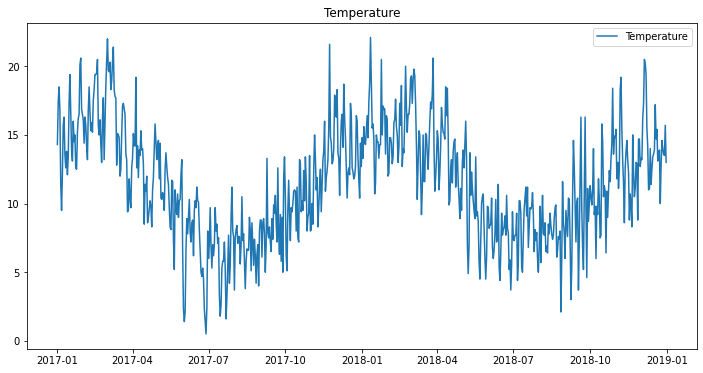

In [108]:
plt.figure(figsize=(12,6))
plt.plot(data_t.Date, data_t['Temperature(Min)'], label='Temperature')
plt.legend(loc='best')
plt.title('Temperature')
plt.show()

## Holts Exponential Smooting

In [117]:
# Import package

from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(np.array(df_t_train['Temperature(Min)']), 
                             seasonal_periods=365, 
                             trend='additive', 
                             seasonal=None)
model_fit = model.fit(smoothing_level=0.5, 
                      smoothing_slope=0.01, 
                      optimized=False)
model_fit.params

{'smoothing_level': 0.5,
 'smoothing_slope': 0.01,
 'smoothing_seasonal': None,
 'damping_slope': nan,
 'initial_level': 14.3,
 'initial_slope': 3.099999999999998,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [118]:
# Make Predictions

y_hat_hes_t = df_t_test.copy()
y_hat_hes_t['Holts_Forecast'] = model_fit.forecast(y_hat_hes_t.shape[0])

In [119]:
# Evaluate the model

from sklearn.metrics import mean_squared_error

RMSE_hes_t = np.sqrt( mean_squared_error(y_true = df_t_test['Temperature(Min)'], y_pred = y_hat_hes_t['Holts_Forecast']))
MAPE_hes_t = np.mean( abs ( (df_t_test['Temperature(Min)']-y_hat_hes_t['Holts_Forecast'])/df_t_test['Temperature(Min)']) )

print (RMSE_hes_t, MAPE_hes_t)

4.114846977880615 0.3416773347194021


## Holts Winter Exponential Smooting

In [120]:
# Import package

from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(np.array(df_t_train['Temperature(Min)']), 
                             seasonal_periods=30, 
                            trend = 'additive',
                            seasonal='additive')
model_fit = model.fit(optimized=True)
model_fit.params
model_fit.params

{'smoothing_level': 0.6747190847471779,
 'smoothing_slope': 3.259836703537761e-27,
 'smoothing_seasonal': 1.4712351059539262e-26,
 'damping_slope': nan,
 'initial_level': 12.377820040974772,
 'initial_slope': 6.130849549703622e-25,
 'initial_seasons': array([3.06464758, 2.57071446, 2.59280805, 3.10300234, 2.57766674,
        2.39920216, 2.50881482, 3.15966749, 3.31076621, 2.99141872,
        3.07234964, 2.8178242 , 1.82193854, 2.77264376, 2.97028588,
        2.99724612, 1.94780486, 2.75722306, 2.45487215, 1.77590578,
        1.99701506, 2.82964802, 1.65667129, 0.96077908, 1.82387124,
        1.82847957, 2.09773582, 2.71386217, 3.2297263 , 3.24573277]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [121]:
# Make Predictions

y_hat_hwa_t = df_t_test.copy()
y_hat_hwa_t['Holts_Forecast'] = model_fit.forecast(y_hat_hwa_t.shape[0])

In [122]:
# Evaluate the model

from sklearn.metrics import mean_squared_error

RMSE_hwa_t = np.sqrt( mean_squared_error(y_true = df_t_test['Temperature(Min)'], y_pred = y_hat_hwa_t['Holts_Forecast']))
MAPE_hwa_t = np.mean( abs ( (df_t_test['Temperature(Min)']-y_hat_hwa_t['Holts_Forecast'])/df_t_test['Temperature(Min)']) )

print (RMSE_hwa_t, MAPE_hwa_t)

3.498585495025293 0.3283129239818765


# Bitcoin Dataset

In [145]:
df_bit = pd.read_csv('bitcoinfinal+(4).csv', header=None)
df_bit.columns = ['Month', 'Price']
df_bit.head(2)

,Month,Price
0,0,217.4
1,1,255.7


In [146]:
df_bit.isnull().sum()

Month    0
Price    0
dtype: int64

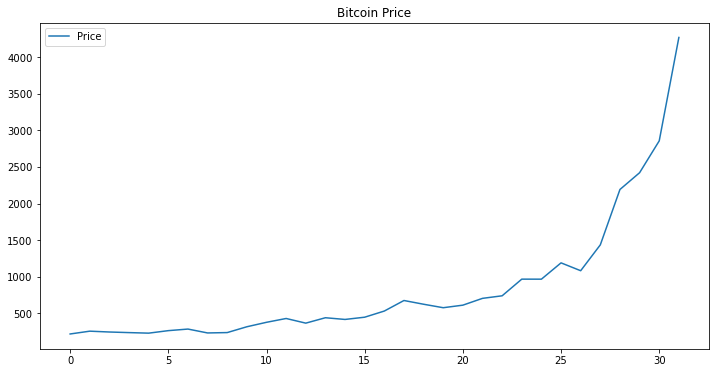

In [147]:
plt.figure(figsize=(12,6))
plt.plot(df_bit.Month, df_bit.Price, label='Price')
plt.legend(loc='best')
plt.title('Bitcoin Price')
plt.show()

In [148]:
# Split into train test
train_len_10 = 29
df_bit_train = df_bit[:train_len_10]
df_bit_test = df_bit[train_len_10:]

In [150]:
# Print
print (df_bit_train.shape)
print (df_bit_train.Price.mean())

(29, 2)
595.7517241379311


In [158]:
# Naive and Simple Avg
y_hat = df_bit_test.copy()
y_hat['Naive'] = df_bit_train['Price'][train_len_10-1]
y_hat['Simple_Avg'] = df_bit_train['Price'].mean()

In [159]:
from sklearn.metrics import mean_squared_error
str_name = 'Naive'
RMSE_val = np.sqrt( mean_squared_error(y_true = df_bit_test['Price'], y_pred = y_hat[str_name]))
MAPE_val = np.mean( abs ( (df_bit_test['Price']-y_hat[str_name])/df_bit_test['Price']) )
print (str_name, 'RMSE= ', round(RMSE_val,3), 'MAPE= ', round(MAPE_val,3))

Naive RMSE=  1265.897 MAPE=  0.271


In [160]:
from sklearn.metrics import mean_squared_error
str_name = 'Simple_Avg'
RMSE_val = np.sqrt( mean_squared_error(y_true = df_bit_test['Price'], y_pred = y_hat[str_name]))
MAPE_val = np.mean( abs ( (df_bit_test['Price']-y_hat[str_name])/df_bit_test['Price']) )
print (str_name, 'RMSE= ', round(RMSE_val,3), 'MAPE= ', round(MAPE_val,3))

Simple_Avg RMSE=  2703.728 MAPE=  0.802


In [169]:
# Simple Moving Avg

y_hat['SMA_12month'] = df_bit_train['Price'].rolling(12).mean()[train_len_10-1]
y_hat['SMA_6month'] = df_bit_train['Price'].rolling(6).mean()[train_len_10-1]
y_hat['SMA_3month'] = df_bit_train['Price'].rolling(3).mean()[train_len_10-1]

In [171]:
from sklearn.metrics import mean_squared_error
str_name = 'SMA_12month'
RMSE_val = np.sqrt( mean_squared_error(y_true = df_bit_test['Price'], y_pred = y_hat[str_name]))
MAPE_val = np.mean( abs ( (df_bit_test['Price']-y_hat[str_name])/df_bit_test['Price']) )
print (str_name, 'RMSE= ', round(RMSE_val,4), 'MAPE= ', round(MAPE_val,4))

SMA_12month RMSE=  2338.9355 MAPE=  0.6742


In [172]:
from sklearn.metrics import mean_squared_error
str_name = 'SMA_6month'
RMSE_val = np.sqrt( mean_squared_error(y_true = df_bit_test['Price'], y_pred = y_hat[str_name]))
MAPE_val = np.mean( abs ( (df_bit_test['Price']-y_hat[str_name])/df_bit_test['Price']) )
print (str_name, 'RMSE= ', round(RMSE_val,4), 'MAPE= ', round(MAPE_val,4))

SMA_6month RMSE=  2035.794 MAPE=  0.5661


In [173]:
from sklearn.metrics import mean_squared_error
str_name = 'SMA_3month'
RMSE_val = np.sqrt( mean_squared_error(y_true = df_bit_test['Price'], y_pred = y_hat[str_name]))
MAPE_val = np.mean( abs ( (df_bit_test['Price']-y_hat[str_name])/df_bit_test['Price']) )
print (str_name, 'RMSE= ', round(RMSE_val,4), 'MAPE= ', round(MAPE_val,4))

SMA_3month RMSE=  1794.9187 MAPE=  0.4781


In [179]:
# Simple Exponential Smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
model = SimpleExpSmoothing(df_bit_train['Price'])
model_fit = model.fit(optimized=True)
y_hat['SES'] = model_fit.forecast(df_bit_test.shape[0])
model_fit.params

{'smoothing_level': 1.0,
 'smoothing_slope': nan,
 'smoothing_seasonal': nan,
 'damping_slope': nan,
 'initial_level': 217.40972806064207,
 'initial_slope': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [182]:
from sklearn.metrics import mean_squared_error
str_name = 'SES'
RMSE_val = np.sqrt( mean_squared_error(y_true = df_bit_test['Price'], y_pred = y_hat[str_name]))
MAPE_val = np.mean( abs ( (df_bit_test['Price']-y_hat[str_name])/df_bit_test['Price']) )
print (str_name, 'RMSE= ', round(RMSE_val,4), 'MAPE= ', round(MAPE_val,4))

SES RMSE=  1265.897 MAPE=  0.2712


In [202]:
# Holts Exponential Smoothing

from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(np.array(df_bit_train['Price']), 
                             seasonal_periods=12, 
                             trend='additive', 
                             seasonal=None)
model_fit = model.fit(optimized=True)
y_hat['Holts'] = model_fit.forecast(df_bit_test.shape[0])
model_fit.params

{'smoothing_level': 1.0,
 'smoothing_slope': 0.42166529254635604,
 'smoothing_seasonal': nan,
 'damping_slope': nan,
 'initial_level': 203.68807684948646,
 'initial_slope': 13.712177705908736,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [203]:
from sklearn.metrics import mean_squared_error
str_name = 'Holts'
RMSE_val = np.sqrt( mean_squared_error(y_true = df_bit_test['Price'], y_pred = y_hat[str_name]))
MAPE_val = np.mean( abs ( (df_bit_test['Price']-y_hat[str_name])/df_bit_test['Price']) )
print (str_name, 'RMSE= ', round(RMSE_val,4), 'MAPE= ', round(MAPE_val,4))

Holts RMSE=  500.1068 MAPE=  0.1101


In [204]:
# Holts Winter Exponential Smoothing

from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(np.array(df_bit_train['Price']), 
                             seasonal_periods=3, 
                             trend='additive', 
                             seasonal='additive')
model_fit = model.fit(optimized=True)
y_hat['Holts_Winter_Additive'] = model_fit.forecast(df_bit_test.shape[0])
model_fit.params

{'smoothing_level': 0.9999,
 'smoothing_slope': 0.42105263157894735,
 'smoothing_seasonal': 0.0001,
 'damping_slope': nan,
 'initial_level': 559.53,
 'initial_slope': 1.1444444444444395,
 'initial_seasons': array([-342.13, -303.83, -315.23]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [205]:
from sklearn.metrics import mean_squared_error
str_name = 'Holts_Winter_Additive'
RMSE_val = np.sqrt( mean_squared_error(y_true = df_bit_test['Price'], y_pred = y_hat[str_name]))
MAPE_val = np.mean( abs ( (df_bit_test['Price']-y_hat[str_name])/df_bit_test['Price']) )
print (str_name, 'RMSE= ', round(RMSE_val,4), 'MAPE= ', round(MAPE_val,4))

Holts_Winter_Additive RMSE=  509.4926 MAPE=  0.1026


In [212]:
# Holts Winter Exponential Smoothing

from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(np.array(df_bit_train['Price']), 
                             seasonal_periods=3, 
                             trend='additive', 
                             seasonal='multiplicative')
model_fit = model.fit(optimized=True)
y_hat['Holts_Winter_Mult'] = model_fit.forecast(df_bit_test.shape[0])
model_fit.params

{'smoothing_level': 0.9999,
 'smoothing_slope': 0.3157894736842105,
 'smoothing_seasonal': 0.0001,
 'damping_slope': nan,
 'initial_level': 559.53,
 'initial_slope': 1.1444444444444395,
 'initial_seasons': array([0.38854038, 0.45699069, 0.43661645]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [213]:
from sklearn.metrics import mean_squared_error
str_name = 'Holts_Winter_Mult'
RMSE_val = np.sqrt( mean_squared_error(y_true = df_bit_test['Price'], y_pred = y_hat[str_name]))
MAPE_val = np.mean( abs ( (df_bit_test['Price']-y_hat[str_name])/df_bit_test['Price']) )
print (str_name, 'RMSE= ', round(RMSE_val,4), 'MAPE= ', round(MAPE_val,4))

Holts_Winter_Mult RMSE=  735.3149 MAPE=  0.1538


# Current Employment Statistics Dataset

In [426]:
unemp_df = pd.read_csv('UNRATE.csv', header=None)
unemp_df.columns = ['Date', 'Unrate']
unemp_df['Date'] = pd.to_datetime(unemp_df['Date'],format="%d-%m-%Y")
unemp_df = unemp_df.set_index('Date')
unemp_df.head()

,Unrate
Date,
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5


In [427]:
unemp_df.shape

(867, 1)

In [428]:
unemp_df.isna().sum()

Unrate    0
dtype: int64

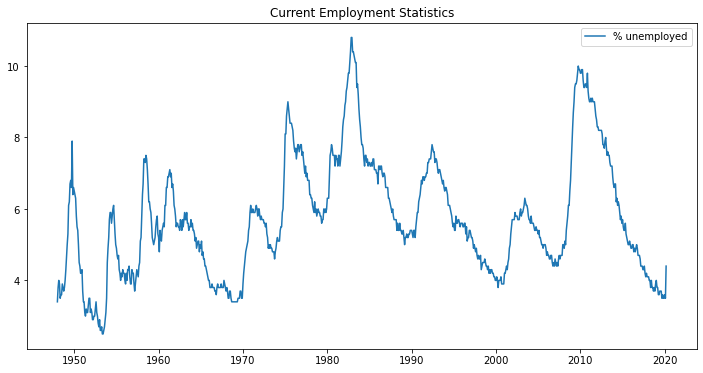

In [429]:
plt.figure(figsize=(12,6))
plt.plot(unemp_df.index, unemp_df.Unrate, label='% unemployed')
plt.legend(loc='best')
plt.title('Current Employment Statistics')
plt.show()

In [430]:
# Split into train test
train_len = 612
train_u = unemp_df[:train_len]
test_u = unemp_df[train_len:]
print (train_u.shape, test_u.shape)

(612, 1) (255, 1)


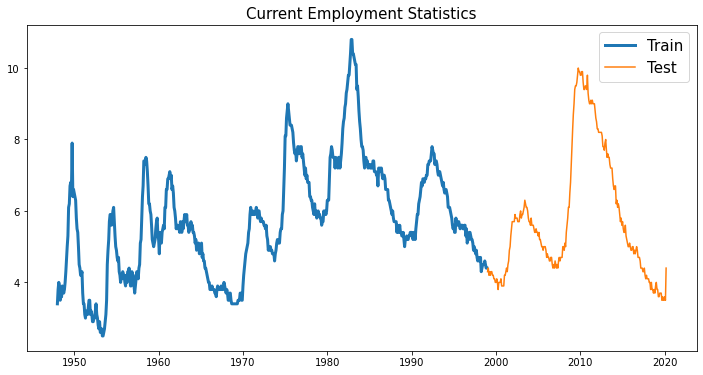

In [431]:
plt.figure(figsize=(12,6))
plt.plot(train_u.index, train_u.Unrate, label='Train', linewidth=3)
plt.plot(test_u.index, test_u.Unrate, label='Test')
plt.legend(loc='best', fontsize=15)
plt.title('Current Employment Statistics', fontsize=15)
plt.show()

In [432]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(unemp_df.Unrate)

print('KPSS Statistic %f' % kpss_test[0])
print ('Critical value @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value %f' % kpss_test[1])

KPSS Statistic 0.464446
Critical value @ 0.05: 0.46
p-value 0.049674


Cannot accept Null Hypothesis. Series is Non Stationary.

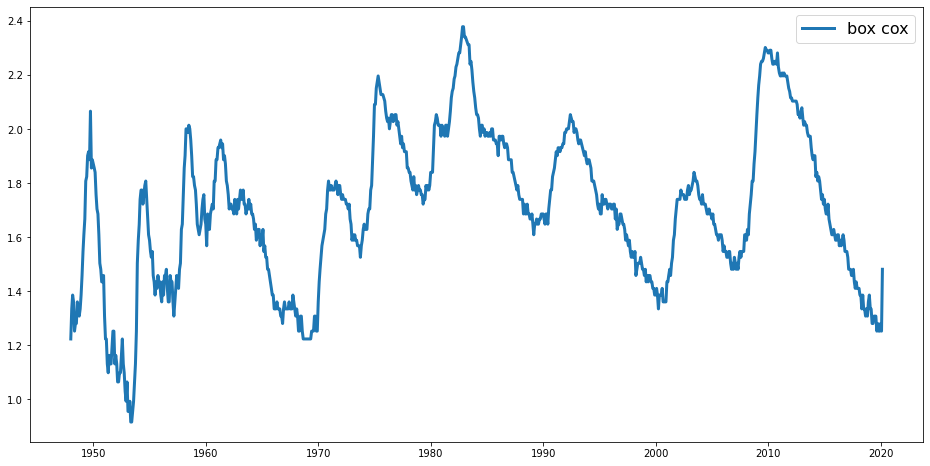

In [433]:
from scipy.stats import boxcox
data_boxcox = pd.Series(boxcox(unemp_df.Unrate, lmbda=0), index = unemp_df.index)

plt.figure(figsize=(16,8))
plt.plot(data_boxcox.index, data_boxcox, label='box cox', linewidth=3)
plt.legend(loc='best', fontsize=16)
plt.show()

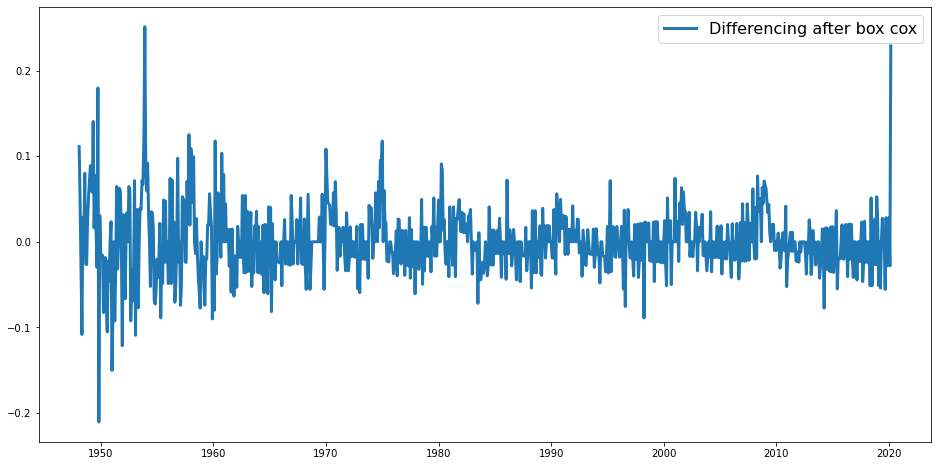

In [434]:
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), index = unemp_df.index)
data_boxcox_diff.dropna(inplace=True)
plt.figure(figsize=(16,8))
plt.plot(data_boxcox_diff.index, data_boxcox_diff, label='Differencing after box cox', linewidth=3)
plt.legend(loc='best', fontsize=16)
plt.show()

In [444]:
# Split into train test

train_len = 612

train_b = data_boxcox[:train_len]
test_b = data_boxcox[train_len:]

train_d = data_boxcox_diff[:train_len-1]
test_d = data_boxcox_diff[train_len-1:]

In [445]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train_d, order=(12,0,0))
model_fit = model.fit()
print (model_fit.params)

const       0.000466
ar.L1.y     0.060690
ar.L2.y     0.161199
ar.L3.y     0.118645
ar.L4.y     0.090456
ar.L5.y     0.107080
ar.L6.y     0.008286
ar.L7.y    -0.029412
ar.L8.y     0.032450
ar.L9.y     0.006198
ar.L10.y   -0.124660
ar.L11.y    0.047125
ar.L12.y   -0.148533
dtype: float64


In [462]:
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['ar_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox_diff'].cumsum() # Opp of Diffrencing
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox'].add(data_boxcox[0]) # First row addition
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])

In [463]:
t_need =  pd.to_datetime('01-06-1948',format="%d-%m-%Y")
t_need

Timestamp('1948-06-01 00:00:00')

In [464]:
y_hat_ar['ar_forecast'] 

1948-02-01    3.901819
1948-03-01    3.960922
1948-04-01    4.082803
1948-05-01    4.188015
1948-06-01    4.210204
                ...   
2019-11-01    5.791548
2019-12-01    5.794250
2020-01-01    5.796952
2020-02-01    5.799656
2020-03-01    5.802362
Freq: MS, Length: 866, dtype: float64

In [465]:
# RMSE and MAPE
from sklearn.metrics import mean_squared_error
RMSE_AR = np.sqrt(mean_squared_error(y_true=test_u['Unrate'], y_pred=y_hat_ar.ar_forecast[test_u.index.min():]))
MAPE_AR = np.mean ( abs(test_u['Unrate'] - y_hat_ma.ma_forecast[test_u.index.min():]) / test_u['Unrate'] ) * 100

In [466]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train_d, order=(0,0,5))
model_fit = model.fit()
print (model_fit.params)

const      0.000507
ma.L1.y    0.055504
ma.L2.y    0.181882
ma.L3.y    0.123451
ma.L4.y    0.099834
ma.L5.y    0.151700
dtype: float64


In [468]:
y_hat_ma = data_boxcox_diff.copy()
y_hat_ma['ma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox_diff'].cumsum() # Opp of Differencing
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox'].add(data_boxcox[0]) # First row addition
y_hat_ma['ma_forecast'] = np.exp(y_hat_ma['ma_forecast_boxcox'])

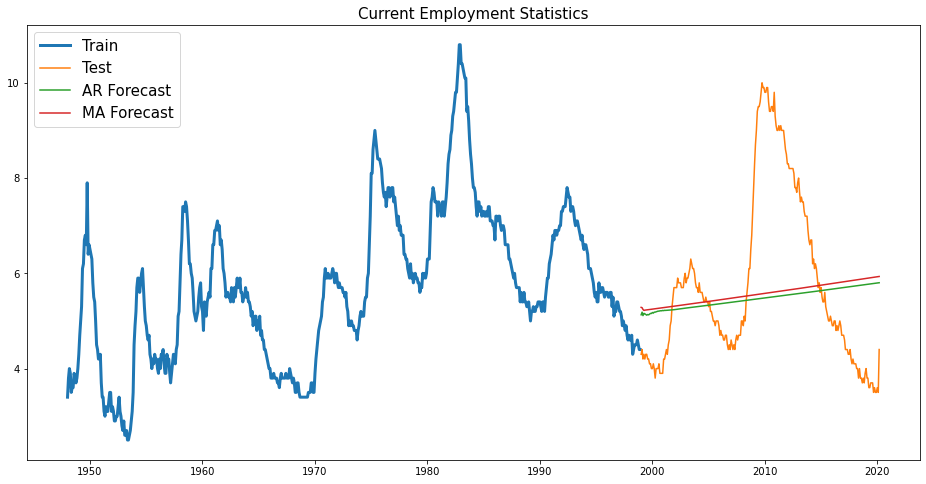

In [469]:
plt.figure(figsize=(16,8))

plt.plot(train_u.index, train_u.Unrate, label='Train', linewidth=3)
plt.plot(test_u.index, test_u.Unrate, label='Test')
plt.plot(y_hat_ar.ar_forecast[test_u.index.min():], label='AR Forecast')
plt.plot(y_hat_ma.ma_forecast[test_u.index.min():], label='MA Forecast')

plt.legend(loc='best', fontsize=15)
plt.title('Current Employment Statistics', fontsize=15)
plt.show()

In [470]:
y_hat_ma['ma_forecast'] 

1948-02-01    3.901980
1948-03-01    3.950280
1948-04-01    4.057868
1948-05-01    4.143129
1948-06-01    4.141527
                ...   
2019-11-01    5.921776
2019-12-01    5.924781
2020-01-01    5.927789
2020-02-01    5.930797
2020-03-01    5.933808
Freq: MS, Length: 866, dtype: float64

In [442]:
# RMSE and MAPE
from sklearn.metrics import mean_squared_error
RMSE_MA = np.sqrt(mean_squared_error(y_true=test_u['Unrate'], y_pred=y_hat_ma.ma_forecast[test_u.index.min():]))
MAPE_MA = np.mean ( abs(test_u['Unrate'] - y_hat_ma.ma_forecast[test_u.index.min():]) / test_u['Unrate'] ) * 100

In [454]:
# Define Dataframe
df_results = pd.DataFrame()
df_results['Method'] = ['AR', 'MA']
df_results['RMSE'] = [RMSE_AR, RMSE_MA]
df_results['MAPE'] = [MAPE_AR, MAPE_MA]
df_results

,Method,RMSE,MAPE
0,AR,1.830590,23.191117
1,MA,1.845228,23.191117


In [471]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train_b, order=(12,1,5)) # Pass Training Data After BoxCox
model_fit = model.fit()
print (model_fit.params)

const         0.000446
ar.L1.D.y    -0.433949
ar.L2.D.y     0.809396
ar.L3.D.y     0.772578
ar.L4.D.y    -0.551658
ar.L5.D.y    -0.810522
ar.L6.D.y     0.075652
ar.L7.D.y     0.063911
ar.L8.D.y     0.068696
ar.L9.D.y     0.186228
ar.L10.D.y    0.019166
ar.L11.D.y   -0.071245
ar.L12.D.y   -0.067813
ma.L1.D.y     0.463084
ma.L2.D.y    -0.639848
ma.L3.D.y    -0.599538
ma.L4.D.y     0.622206
ma.L5.D.y     0.871443
dtype: float64


In [472]:
y_hat_arima = data_boxcox_diff.copy()
y_hat_arima['arima_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox_diff'].cumsum()
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox'].add(data_boxcox[0])
y_hat_arima['arima_forecast'] = np.exp(y_hat_arima['arima_forecast_boxcox'])

In [473]:
# RMSE and MAPE
from sklearn.metrics import mean_squared_error
RMSE_ARIMA = np.sqrt(mean_squared_error(y_true=test_u['Unrate'], y_pred=y_hat_arima.arima_forecast[test_u.index.min():]))
MAPE_ARIMA = np.mean ( abs(test_u['Unrate'] - y_hat_arima.arima_forecast[test_u.index.min():]) / test_u['Unrate'] ) * 100

new_row = {'Method': 'ARIMA Method', 'RMSE': RMSE_ARIMA, 'MAPE': MAPE_ARIMA}
df_results = df_results.append(new_row, ignore_index=True)
df_results

,Method,RMSE,MAPE
0,AR,1.830590,23.191117
1,MA,1.845228,23.191117
2,ARIMA Method,1.858206,22.924451


In [474]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train_b, order=(2,1,4), seasonal_order = (2,1,4,12))
model_fit = model.fit()
print (model_fit.params)

ar.L1       0.603301
ar.L2       0.112826
ma.L1      -0.566291
ma.L2       0.004751
ma.L3       0.069745
ma.L4       0.053141
ar.S.L12   -0.931474
ar.S.L24   -0.505614
ma.S.L12   -0.282562
ma.S.L24   -0.538805
ma.S.L36   -0.392376
ma.S.L48    0.267979
sigma2      0.001494
dtype: float64


In [475]:
y_hat_sarima = data_boxcox_diff.copy()
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

In [476]:
# RMSE and MAPE
from sklearn.metrics import mean_squared_error
RMSE_SARIMA = np.sqrt(mean_squared_error(y_true=test_u['Unrate'], y_pred=y_hat_sarima.sarima_forecast[test_u.index.min():]))
MAPE_SARIMA = np.mean ( abs(test_u['Unrate'] - y_hat_sarima.sarima_forecast[test_u.index.min():]) / test_u['Unrate'] ) * 100

new_row = {'Method': 'SARIMA Method', 'RMSE': RMSE_SARIMA, 'MAPE': MAPE_SARIMA}
df_results = df_results.append(new_row, ignore_index=True)
df_results

,Method,RMSE,MAPE
0,AR,1.830590,23.191117
1,MA,1.845228,23.191117
2,ARIMA Method,1.858206,22.924451
3,SARIMA Method,2.264401,22.201572


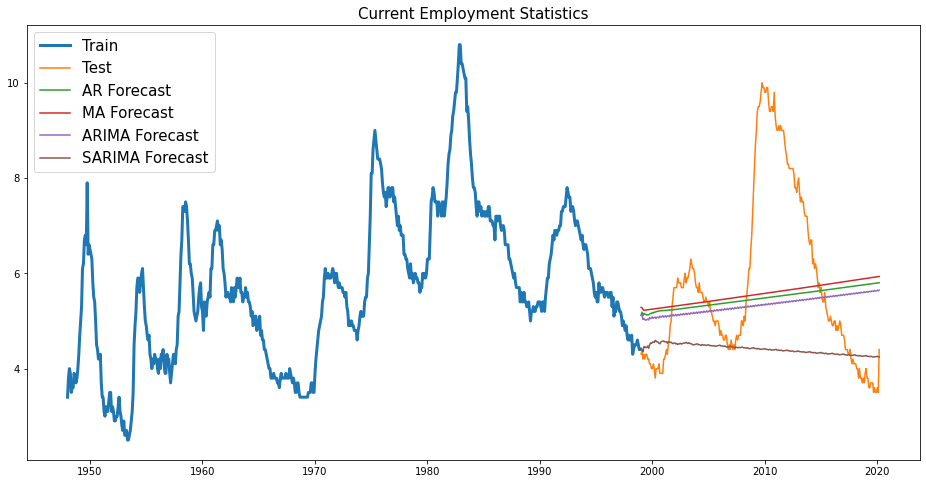

In [477]:
plt.figure(figsize=(16,8))

plt.plot(train_u.index, train_u.Unrate, label='Train', linewidth=3)
plt.plot(test_u.index, test_u.Unrate, label='Test')
plt.plot(y_hat_ar.ar_forecast[test_u.index.min():], label='AR Forecast')
plt.plot(y_hat_ma.ma_forecast[test_u.index.min():], label='MA Forecast')
plt.plot(y_hat_arima.arima_forecast[test_u.index.min():], label='ARIMA Forecast')
plt.plot(y_hat_sarima.sarima_forecast[test_u.index.min():], label='SARIMA Forecast')

plt.legend(loc='best', fontsize=15)
plt.title('Current Employment Statistics', fontsize=15)
plt.show()

# Daily Temperature 1 Dataset

In [480]:
dd = pd.read_csv('Temperature2.csv')
dd['Year-Month'] = pd.to_datetime(dd['Year-Month'],format="%Y-%m")
dd.head()

,year,month,Year-Month,Temperature
0,2015,1,2015-01-01,-0.2
1,2015,2,2015-02-01,1.2
2,2015,3,2015-03-01,4.6
3,2015,4,2015-04-01,9.9
4,2015,5,2015-05-01,15.1


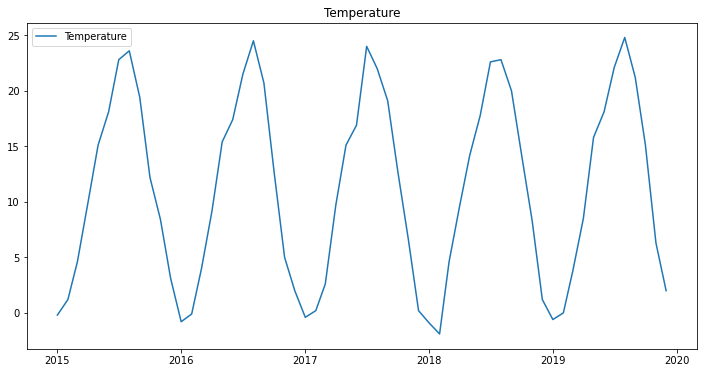

In [481]:
plt.figure(figsize=(12,6))
plt.plot(dd['Year-Month'], dd.Temperature, label='Temperature')
plt.legend(loc='best')
plt.title('Temperature')
plt.show()

In [483]:
dd.shape

(60, 4)

# Exchange Rate dataset

In [486]:
dd = pd.read_csv('Exchange+Rate+1.csv')
dd['Date'] = pd.to_datetime(dd['Date'],format="%d-%m-%Y")
dd.head()

,Date,Exchange Rate
0,2019-08-12,0.8919
1,2019-08-13,0.8943
2,2019-08-14,0.8973
3,2019-08-15,0.9004
4,2019-08-16,0.9016


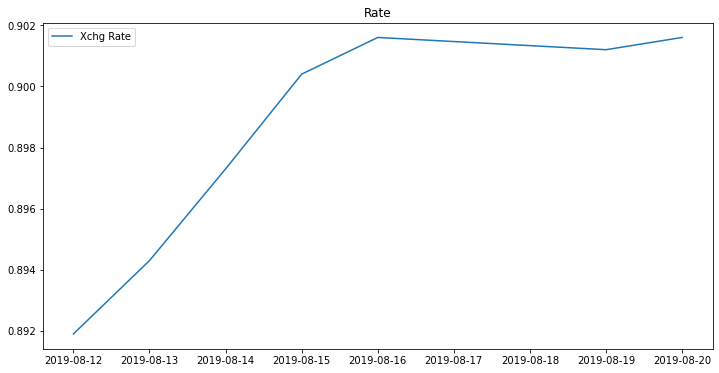

In [487]:
plt.figure(figsize=(12,6))
plt.plot(dd['Date'], dd['Exchange Rate'], label='Xchg Rate')
plt.legend(loc='best')
plt.title('Rate')
plt.show()

In [488]:
dd.shape

(7, 2)

In [491]:
tddd = dd[:5]
np.mean(tddd['Exchange Rate'])

0.8971

In [495]:
tddd

,Date,Exchange Rate
0,2019-08-12,0.8919
1,2019-08-13,0.8943
2,2019-08-14,0.8973
3,2019-08-15,0.9004
4,2019-08-16,0.9016


In [494]:
tessss = dd[5:]
tessss

,Date,Exchange Rate
5,2019-08-19,0.9012
6,2019-08-20,0.9016


# Exchange Rate dataset

In [496]:
dd = pd.read_csv('Exchange+Rate+2.csv')
dd['Date'] = pd.to_datetime(dd['Date'],format="%d-%m-%Y")
dd.head()

,Date,Exchange Rate
0,2019-03-01,0.8790
1,2019-03-04,0.8828
2,2019-03-05,0.8850
3,2019-03-06,0.8834
4,2019-03-07,0.8917


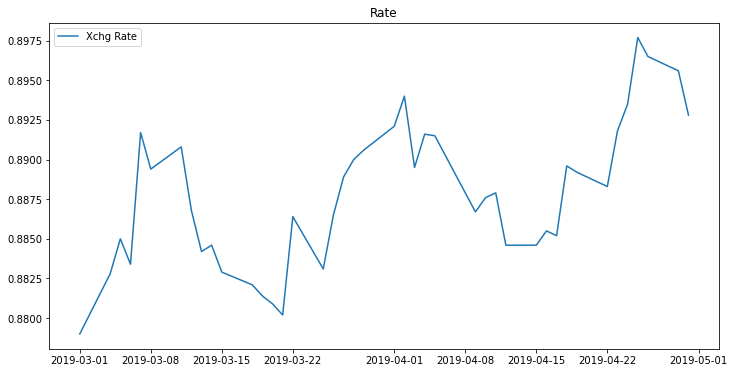

In [497]:
plt.figure(figsize=(12,6))
plt.plot(dd['Date'], dd['Exchange Rate'], label='Xchg Rate')
plt.legend(loc='best')
plt.title('Rate')
plt.show()